# Setup

In [1]:
from __future__ import absolute_import, division, print_function

import os
import re
import json
import gzip
from collections import defaultdict, Counter
from operator import itemgetter

import numpy as np
import pandas as pd
from scipy.stats import fisher_exact, spearmanr, gaussian_kde, norm
from statsmodels.sandbox.stats.multicomp import multipletests

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator

from IPython.display import display

%matplotlib inline

pd.options.display.max_columns = 200

plt.style.use('ggplot')
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = '#888888'
mpl.rcParams['grid.color'] = '#eeeeee'

def summarize(df, n = 5):
    display(df.head(n))
    print('%d records' % len(df))
    
def multipletests_with_nulls(values, method = 'fdr_bh'):
    significance = np.nan * np.empty(len(values))
    qvals = np.nan * np.empty(len(values))
    mask = pd.notnull(values)
    significance[np.array(mask)], qvals[np.array(mask)], _, _ = multipletests(values[mask], method = method)
    return significance.astype(bool), qvals

def draw_heat_map(df, figsize, reverse_order = True, row_labels = None, cmap = 'RdBu'):
    
    if row_labels is None:
        row_labels = df.index      
        
    if reverse_order:
        df = df.iloc[::-1]
        row_labels = row_labels.loc[::-1]
    
    fig, ax = plt.subplots(figsize = figsize)
    abs_max = df.abs().max().max()
    heatmap = ax.pcolor(df.fillna(0), cmap = cmap, vmin = -abs_max, vmax = abs_max)

    ax.set_xticks(np.arange(len(df.columns)) + 0.5)
    ax.set_xticklabels(df.columns, rotation = 'vertical')
    ax.set_yticks(np.arange(len(df.index)) + 0.5)
    ax.set_yticklabels(row_labels)

    fig.colorbar(heatmap)

In [2]:
# You may change these directories if you prefer to work in other locations
DATA_DIR = os.path.expanduser('~/tcga_and_exac_analysis')
FABRIC_DATA_DIR = os.path.expanduser('~/fabric_data')

# Combine GDC's downloaded tar file into a single MAF file

Use the following code to combine files downloaded from the GDC data portal (https://portal.gdc.cancer.gov/repository) into a single MAF files.

For example, you can download all cancer somatic mutations provided by TCGA, by applying the following filters:
1. Select "MuTect2 ..." as the "Workflow Type"
2. Select "MAF" as the "Data Format"
3. Select "open" Access

Download the resulted query in TSV format to obtain a .tar.gz file with the requested MAF files, and save it inside the DATA_DIR you configured. 

In [ ]:
import tarfile

projects = Counter()
tools = Counter()
maf_dfs = []

with tarfile.open(os.path.join(DATA_DIR, 'gdc_download_20170814_182452.tar.gz')) as tar:
    for subtar in tar:
        if subtar.isfile():
            if subtar.path.endswith('.maf.gz'):

                (project, tool), = re.findall('TCGA.([A-Z]+).([a-z]+)', subtar.path)
                projects[project] += 1
                tools[tool] += 1

                if tool == 'mutect':
                    f = gzip.GzipFile(fileobj = tar.extractfile(subtar), mode = 'rb')
                    maf_df = pd.read_csv(f, delimiter = '\t', comment = '#')
                    maf_df['tcga_project'] = project
                    maf_dfs.append(maf_df)
            else:
                print('Irrelevant file: %s' % subtar.path)

print('Tools: %s' % dict(tools))
print('Projects: %s' % dict(projects))

combined_maf_df = pd.concat(maf_dfs)
del maf_dfs

summarize(combined_maf_df)

In [ ]:
combined_maf_df.to_csv(os.path.join(DATA_DIR, 'gdc_combined.maf'), index = False, sep = '\t')

# TCGA Analysis

In [3]:
if 'combined_maf_df' in globals():
    maf = combined_maf_df
else:
    maf = pd.read_csv(os.path.join(DATA_DIR, 'gdc_combined.maf'), delimiter = '\t')
    
summarize(maf)
relevant_mutations = maf[maf['Variant_Type'] == 'SNP']

/cs/proto_nadavb/my_python/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,20,28,87,88,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_File,Sequencer,Tumor_Sample_UUID,Matched_Norm_Sample_UUID,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,Exon_Number,t_depth,t_ref_count,t_alt_count,n_depth,n_ref_count,n_alt_count,all_effects,Allele,Gene,Feature,Feature_type,One_Consequence,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,TRANSCRIPT_STRAND,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,RefSeq,SIFT,PolyPhen,EXON,INTRON,DOMAINS,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EAS_MAF,EUR_MAF,SAS_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,IMPACT,PICK,VARIANT_CLASS,TSL,HGVS_OFFSET,PHENO,MINIMISED,ExAC_AF,ExAC_AF_Adj,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,GENE_PHENO,FILTER,CONTEXT,src_vcf_id,tumor_bam_uuid,normal_bam_uuid,case_id,GDC_FILTER,COSMIC,MC3_Overlap,GDC_Validation_Status,tcga_project
0,DDI2,84301,BI,GRCh38,chr1,15643572,15643572,+,Missense_Mutation,SNP,A,A,G,novel,NaN,TCGA-63-A5MU-01A-11D-A26M-08,TCGA-63-A5MU-10A-01D-A26K-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,cc2f5c0e-30ae-4cf8-bd6d-25f08445bc65,9712d33a-a681-4c9d-97f5-c4f3fa8db67c,c.811A>G,p.Met271Val,p.M271V,ENST00000480945,6/10,124,51,73,146,NaN,NaN,"DDI2,missense_variant,p.M271V,ENST00000480945,...",G,ENSG00000197312,ENST00000480945,Transcript,missense_variant,missense_variant,982/10625,811/1200,271/399,M/V,Atg/Gtg,NaN,1,NaN,1.0,DDI2,HGNC,HGNC:24578,protein_coding,YES,CCDS30607.1,ENSP00000417748,Q5TDH0,NaN,UPI0000470AD7,NM_032341.4,deleterious(0.01),benign(0.113),6/10,NaN,Pfam_domain:PF09668;Pfam_domain:PF08284;Pfam_d...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MODERATE,1.0,SNV,2.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,ACATAATGAGA,3b160723-90c2-4c60-9bb1-e24bfde5e142,be43d7f0-61de-44a8-8932-3979e6fd8d73,efcd5a51-32d5-4b29-a535-0b96cf2f621a,7625a27d-a012-4f4d-b637-5f85d7cdae8c,NaN,NaN,True,Unknown,LUSC
1,NECAP2,55707,BI,GRCh38,chr1,16440797,16440797,+,Silent,SNP,C,C,T,NaN,NaN,TCGA-63-A5MU-01A-11D-A26M-08,TCGA-63-A5MU-10A-01D-A26K-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,cc2f5c0e-30ae-4cf8-bd6d-25f08445bc65,9712d33a-a681-4c9d-97f5-c4f3fa8db67c,c.36C>T,p.=,p.V12V,ENST00000337132,1/8,67,45,22,85,NaN,NaN,"NECAP2,synonymous_variant,p.V12V,ENST000003371...",T,ENSG00000157191,ENST00000337132,Transcript,synonymous_variant,synonymous_variant,126/2070,36/792,12/263,V,gtC/gtT,NaN,1,NaN,1.0,NECAP2,HGNC,HGNC:25528,protein_coding,NaN,CCDS173.1,ENSP00000338746,Q9NVZ3,A0A024QZ81,UPI000006F33F,NM_018090.4,NaN,NaN,1/8,NaN,Pfam_domain:PF07933;Superfamily_domains:SSF50729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LOW,NaN,SNV,1.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,TGTGTCAAGCC,3b160723-90c2-4c60-9bb1-e24bfde5e142,be43d7f0-61de-44a8-8932-3979e6fd8d73,efcd5a51-32d5-4b29-a535-0b96cf2f621a,7625a27d-a012-4f4d-b637-5f85d7cdae8c,NaN,COSM3789050;COSM3789051,True,Unknown,LUSC
2,CROCCP2,84809,BI,GRCh38,chr1,16619196,16619196,+,RNA,SNP,G,G,A,novel,NaN,TCGA-63-A5MU-01A-11D-A26M-08,TCGA-63-A5MU-10A-01D-A26K-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,cc2f5c0e-30ae-4cf8-bd6d-25f08445bc65,9712d33a-a681-4c9d-97f5-c4f3fa8db67c,n.1829C>T,NaN,NaN,ENST00000412962,8/8,132,123,9,320,NaN,NaN,"CROCCP2,non_coding_transcript_exon_variant,,EN...",A,ENSG00000215908

3175929 records


## General statistics

In [ ]:
# There are three equivallent ways to identify samples.

for column in ['Tumor_Sample_Barcode', 'src_vcf_id', 'case_id']:
    print('%s: %d unique values.' % (column, len(maf[column].unique())))

summarize(maf[['Tumor_Sample_Barcode', 'src_vcf_id', 'case_id']].drop_duplicates())

In [ ]:
display(maf['FILTER'].value_counts().head())
display(maf['GDC_FILTER'].value_counts().head())
display(maf['GDC_Validation_Status'].value_counts())
display(maf['Sequencer'].value_counts())

display(maf['Mutation_Status'].value_counts())
display(maf['NCBI_Build'].value_counts())
display(maf['Strand'].value_counts())
display(maf['Chromosome'].value_counts())

display(maf['Variant_Type'].value_counts())
display(maf['Variant_Classification'].value_counts())

print('%d unique gene symbols.' % len(maf['Hugo_Symbol'].unique()))

In [ ]:
# All over the board we have: Reference_Allele == Tumor_Seq_Allele1 != Tumor_Seq_Allele2 == Allele
assert (maf['Reference_Allele'] == maf['Tumor_Seq_Allele1']).all()
assert (maf['Reference_Allele'] != maf['Tumor_Seq_Allele2']).all()
assert (maf['Tumor_Seq_Allele2'] == maf['Allele']).all()

## Project (cancer-type) statistics

In [4]:
# Download from: https://portal.gdc.cancer.gov/projects ("TSV" download button)
tcga_projects = pd.read_csv(os.path.join(DATA_DIR, 'tcga-projects-table.tsv'), sep = '\t', thousands = ',')

def get_project_reported_fields(project):
    (_, record), = tcga_projects[tcga_projects['Project'].str.contains(project).fillna(False)].iterrows()
    return record[['Seq', 'Disease Type', 'Primary Site']]

project_summaries = maf['tcga_project'].value_counts().sort_index().rename('n_mutations').to_frame()
project_summaries['n_samples'] = maf.groupby('tcga_project')['Tumor_Sample_Barcode'].unique().apply(len)

n_mutations_per_sample = maf.groupby(['tcga_project', 'Tumor_Sample_Barcode']).size().rename('n_mutations_per_sample')\
        .to_frame().reset_index()
n_mutations_per_sample_agg = n_mutations_per_sample.groupby('tcga_project')['n_mutations_per_sample'].agg(\
        ['mean', 'std']).rename(columns = lambda name: '%s_mutations_per_sample' % name)
project_summaries = pd.concat([project_summaries, n_mutations_per_sample_agg], axis = 1)

reported_fields = project_summaries.index.map(get_project_reported_fields)
reported_fields = pd.concat(reported_fields, axis = 1).transpose().set_index(project_summaries.index)
reported_fields.rename(columns = {'Seq': 'total_tcga_seqed_samples', 'Disease Type': 'disease', \
        'Primary Site': 'primary_site'}, inplace = True)
reported_fields['total_tcga_seqed_samples'] = reported_fields['total_tcga_seqed_samples'].astype(int)

project_summaries = pd.concat([project_summaries, reported_fields], axis = 1)
project_summaries.sort_values('n_samples', ascending = False, inplace = True)
project_summaries.reset_index(inplace = True)
project_summaries = project_summaries[['tcga_project', 'primary_site', 'disease', 'total_tcga_seqed_samples', 'n_samples', \
        'n_mutations', 'mean_mutations_per_sample', 'std_mutations_per_sample']]

print('Project summaries:')
display(project_summaries)

print('Total:')
display(project_summaries[['total_tcga_seqed_samples', 'n_samples', 'n_mutations']].sum().astype(int))

print('TCGA projects not present in the dataset:')
display(tcga_projects[~tcga_projects['Disease Type'].isin(project_summaries['disease'])])

Project summaries:


,tcga_project,primary_site,disease,total_tcga_seqed_samples,n_samples,n_mutations,mean_mutations_per_sample,std_mutations_per_sample
0,BRCA,Breast,Breast Invasive Carcinoma,1098,986,120988,122.705882,347.775315
1,LUAD,Lung,Lung Adenocarcinoma,582,567,208180,367.160494,386.347251
2,UCEC,Uterus,Uterine Corpus Endometrial Carcinoma,559,530,886377,1672.409434,4159.661392
3,HNSC,Head and Neck,Head and Neck Squamous Cell Carcinoma,528,508,102309,201.395669,288.087653
4,LGG,Brain,Brain Lower Grade Glioma,516,508,35556,69.992126,635.728218
5,PRAD,Prostate,Prostate Adenocarcinoma,498,495,29286,59.163636,408.267664
6,LUSC,Lung,Lung Squamous Cell Carcinoma,504,492,181116,368.121951,317.639745
7,THCA,Thyroid,Thyroid Carcinoma,507,492,10899,22.152439,52.296615
8,SKCM,Skin,Skin Cutaneous Melanoma,470,467,392571,840.623126,1423.392934
9,STAD,Stomach,Stomach Adenocarcinoma,443,437,213144,487.743707,929.349515


Total:


total_tcga_seqed_samples      10995
n_samples                     10182
n_mutations                 3175929
dtype: int64

TCGA projects not present in the dataset:


,Project,Disease Type,Primary Site,Program,Cases,Seq,Exp,SNV,CNV,Meth,Clinical,Bio,Files
0,TARGET-NBL,Neuroblastoma,Nervous System,TARGET,1127,270,151,216,0,0,7,1127,2806
3,TARGET-WT,High-Risk Wilms Tumor,Kidney,TARGET,652,128,128,34,0,0,652,652,1324
18,TARGET-OS,Osteosarcoma,Bone,TARGET,381,0,0,0,0,0,282,381,4
34,TARGET-RT,Rhabdoid Tumor,Kidney,TARGET,75,44,44,0,0,0,69,75,174
38,TARGET-CCSK,Clear Cell Sarcoma of the Kidney,Kidney,TARGET,13,0,0,0,0,0,13,13,2
39,NaN,NaN,NaN,NaN,14551,11736,11134,10687,10995,10943,13118,14551,274724


## Mutations per sample

In [ ]:
n_mutations_per_sample = maf['Tumor_Sample_Barcode'].value_counts()

fig, ax = plt.subplots(figsize = (10, 6))
ax.hist(np.log10(n_mutations_per_sample), bins = 20)
ax.set_xlabel('Log10 # Mutations')
ax.set_ylabel('# Samples')

## Processing TCGA results

This section is a downstream analysis to the results obtained by FABRIC on the TCGA analysis (in &lt;DATA_DIR&gt;/gdc_results/), i.e. after running:

analyze_maf_genes --reference-genome=GRCh38 --gene-dataset-dir=~/fabric_data/ --maf-file=~/tcga_and_exac_analysis/gdc_combined.maf --effect-scores-csv-file=~/tcga_and_exac_analysis/gdc_effect_scores.csv --gene-bg-scores-dir=~/fabric_data/gene_bg_scores/ --output-dir=~/tcga_and_exac_analysis/gdc_results/ --analyze-diff

(follow the instructions in the README file in the repository)

In [5]:
'''
Loading external driver databases to compare against.
'''

DRIVER_DBS_DIR = os.path.join(DATA_DIR, 'driver_databases')


# Download Census data from: http://cancer.sanger.ac.uk/census/

census_df = pd.read_csv(os.path.join(DRIVER_DBS_DIR, 'census_all_2017_08_12.csv'))

print('Census:')
display(census_df.head(3))

gene_symbol_to_census_cancer_role = census_df.set_index('Gene Symbol', drop = True)['Role in Cancer']


# Download CCGD data from: http://ccgd-starrlab.oit.umn.edu/download.php

ccgd_df = pd.read_csv(os.path.join(DRIVER_DBS_DIR, 'ccgd.csv'))
ccgd_df['COSMIC'] = ccgd_df['COSMIC'].map({'Yes': True, 'No': False})
ccgd_df['CGC'] = ccgd_df['CGC'].map({'Yes': True, 'No': False})

print('CCGD:')
display(ccgd_df.head(3))

gene_symbol_to_ccgd_annotations = {}

for gene_symbol, ccgd_records in ccgd_df.groupby('Human Symbol'):
    
    n_studies = set(ccgd_records['Studies'])
    
    try:
        n_studies_value, = n_studies
        assert n_studies_value == len(ccgd_records)
        studies = str(n_studies_value)
    except:
        studies = '%d-%d / %d' % (min(n_studies), max(n_studies), len(ccgd_records))
    
    is_cosmic, = set(ccgd_records['COSMIC'])
    is_cgc, = set(ccgd_records['CGC'])
    relative_ranks = (ccgd_records['Relative Rank'].value_counts() / len(ccgd_records)).to_dict()
    cancer_types = (ccgd_records['Cancer Type'].value_counts() / len(ccgd_records)).to_dict()
    
    gene_symbol_to_ccgd_annotations[gene_symbol] = {
        'studies': studies,
        'is_cosmic': is_cosmic,
        'is_cgc': is_cgc,
        'relative_ranks': relative_ranks,
        'cancer_types': cancer_types,
    }
    
def parse_ccgd_n_studies(ccgd_annotations):
    
    if pd.isnull(ccgd_annotations):
        return 0
    
    try:
        return int(ccgd_annotations['studies'])
    except:
        return 0
        

# MutSig:
# Based on the paper: Discovery and saturation analysis of cancer genes across 21 tumour types
# (https://www.nature.com/nature/journal/v505/n7484/full/nature12912.html)
# Took the 114 genes from Supplementary Table S2 that had a significant combined q-value (based on the column BE in the
# Excel file).

with open(os.path.join(DRIVER_DBS_DIR, 'mutsig.txt'), 'r') as f:
    mutsig_significant_gene_symbols = set([line.strip() for line in f])

print('MutSig: %d genes.' % len(mutsig_significant_gene_symbols))

Census:


,Gene Symbol,Name,Entrez GeneId,Genome Location,Hallmark,Chr Band,Somatic,Germline,Tumour Types(Somatic),Tumour Types(Germline),Cancer Syndrome,Tissue Type,Molecular Genetics,Role in Cancer,Mutation Types,Translocation Partner,Other Germline Mut,Other Syndrome,Synonyms
0,ABI1,abl-interactor 1,10006,10:26748570-26860863,Yes,10p11.2,yes,NaN,AML,NaN,NaN,L,Dom,"TSG, fusion",T,KMT2A,NaN,NaN,"10006,ABI-1,ABI1,E3B1,SSH3BP1"
1,ABL1,v-abl Abelson murine leukemia viral oncogene h...,25,9:130835447-130885683,Yes,9q34.1,yes,NaN,"CML, ALL, T-ALL",NaN,NaN,L,Dom,"oncogene, fusion","T, Mis","BCR, ETV6, NUP214",NaN,NaN,"25,ABL,ABL1,ENSG00000097007,JTK7,P00519,bcr/ab..."
2,ABL2,"c-abl oncogene 2, non-receptor tyrosine kinase",27,1:179107718-179143044,NaN,1q24-q25,yes,NaN,AML,NaN,NaN,L,Dom,"oncogene, fusion",T,ETV6,NaN,NaN,"27,ABL2,ABLL,ARG,ENSG00000143322,P42684,RP11-1..."


CCGD:


,Mouse Symbol,Mouse ID,Mouse Chr,Homologene ID,Human Symbol,Human ID,Rat Symbol,Rat ID,Drosophila Symbol,Drosophila ID,Zebrafish Symbol,Zebrafish ID,Yeast Symbol,Yeast ID,COSMIC,CGC,Study,PubMed ID,Predicted Effect,CIS Address,Relative Rank,Cancer Type,Studies
0,Pten,19211,19,265.0,PTEN,5728,Pten,50557,Pten,43991,ptenb,368415,NaN,NaN,True,True,Bard-Chapeau 2014-01,24316982,Not Determined,19:32757576-32826160,A,Liver Cancer,42
1,Pten,19211,19,265.0,PTEN,5728,Pten,50557,Pten,43991,ptenb,368415,NaN,NaN,True,True,Been 2014-01,24827933,Loss,19:32781300-32831300,B,Blood Cancer,42
2,Pten,19211,19,265.0,PTEN,5728,Pten,50557,Pten,43991,ptenb,368415,NaN,NaN,True,True,Berquam Vrieze 2011-02,21828136,Loss,19:32770143-32808349,B,Blood Cancer,42


MutSig: 114 genes.


In [6]:
SAVE = True
#SAVE = False

RESULTS_DIR = os.path.join(DATA_DIR, 'gdc_results')
COMPLETE_RESULTS_DIR = os.path.join(DATA_DIR, 'gdc_results_complete')

if SAVE:
    os.mkdir(COMPLETE_RESULTS_DIR)
    
def analyze_tcga_flags(results, print_pariwise_results = True):
    
    true_mask = np.array(len(results) * [True])

    n_obs_total = results['n_obs']
    n_obs_synonymous = results['observed_type_counts'].apply(itemgetter(0))
    n_obs_missense = results['observed_type_counts'].apply(itemgetter(1))
    n_obs_nonsense = results['observed_type_counts'].apply(itemgetter(2))
    n_exp_synonymous = n_obs_total * results['expected_type_freqs'].apply(itemgetter(0))
    n_exp_missense = n_obs_total * results['expected_type_freqs'].apply(itemgetter(1))
    n_exp_nonsense = n_obs_total * results['expected_type_freqs'].apply(itemgetter(2))
    ccgd_n_studies = results['ccgd_annotations'].apply(parse_ccgd_n_studies)

    flags = [
        ('alteration_promoting_by_overall_scores', true_mask, results['overall_fdr_significance'].fillna(False) & \
                (results['overall_z_value'] < 0)),
        ('alteration_promoting_by_missense_scores', true_mask, results['missense_fdr_significance'].fillna(False) & \
                (results['missense_z_value'] < 0)),
        ('alteration_promoting_by_types', (n_exp_synonymous >= 5) & (n_exp_missense >= 5) & (n_exp_nonsense >= 5), \
                results['types_chi2_fdr_significance'].fillna(False) & ((n_obs_nonsense > n_exp_nonsense) | \
                (n_obs_synonymous < n_exp_synonymous))),
        ('driver_by_mutsig', true_mask, results['mutsig_significant']),
        ('census_any', true_mask, results['census_cancer_role'].notnull()),
        ('census_TSG', true_mask, results['census_cancer_role'].str.contains('TSG')),
        ('census_TSG_only', true_mask, results['census_cancer_role'] == 'TSG'),
        ('census_fusion', true_mask, results['census_cancer_role'].str.contains('fusion')),
        ('census_fusion_only', true_mask, results['census_cancer_role'] == 'fusion'),
        ('census_oncogene', true_mask, results['census_cancer_role'].str.contains('oncogene')),
        ('census_oncogene_only', true_mask, results['census_cancer_role'] == 'oncogene'),
        ('ccgd_more_than_5_studies', true_mask, ccgd_n_studies >= 5),
        ('ccgd_more_than_10_studies', true_mask, ccgd_n_studies >= 10),
        ('ccgd_more_than_20_studies', true_mask, ccgd_n_studies >= 20),
    ]
    
    print('Total: %d genes.' % len(results))

    for flag_name, flag_prerequisite_mask, flag_mask in flags:
        flag_mask = flag_mask & flag_prerequisite_mask
        results[flag_name] = flag_mask
        print('%s: %d of %d (%.2f%%)' % (flag_name, flag_mask.sum(), flag_prerequisite_mask.sum(), \
                100 * flag_mask.sum() / flag_prerequisite_mask.sum()))

    flag_names = zip(*flags)[0]
    pairwise_enrichment_results = pd.DataFrame('{}', index = flag_names, columns = flag_names)

    for i, (flag_name1, flag_prerequisite_mask1, flag_mask1) in enumerate(flags):
        
        flag_mask1 = flag_mask1 & flag_prerequisite_mask1
        obs1 = flag_mask1.sum()

        for j in range(i + 1, len(flags)):

            flag_name2, flag_prerequisite_mask2, flag_mask2 = flags[j]
            flag_mask2 = flag_mask2 & flag_prerequisite_mask2
            obs2 = flag_mask2.sum()

            prerequisite_mask = flag_prerequisite_mask1 & flag_prerequisite_mask2
            total = prerequisite_mask.sum()
            obs = (flag_mask1 & flag_mask2).sum()
            expected = obs1 * obs2 / total
            enrichment = obs / expected

            not_flag_mask1 = (~flag_mask1) & prerequisite_mask
            not_flag_mask2 = (~flag_mask2) & prerequisite_mask
            _, pval = fisher_exact([[(flag_mask1 & flag_mask2).sum(), (flag_mask1 & not_flag_mask2).sum()], \
                    [(not_flag_mask1 & flag_mask2).sum(), (not_flag_mask1 & not_flag_mask2).sum()]])

            enrichment_result = {
                'name1': flag_name1,
                'name2': flag_name2,
                'obs1': obs1,
                'obs2': obs2,
                'obs': obs,
                'total': total,
                'expected': expected,
                'enrichment': enrichment,
                'pval': pval,
                'percentage1': 100 * obs / (flag_mask1 & prerequisite_mask).sum(),
                'percentage2': 100 * obs / (flag_mask2 & prerequisite_mask).sum(),
            }
            
            json_enrichment_result = json.dumps(enrichment_result)
            pairwise_enrichment_results.iloc[i, j] = json_enrichment_result
            pairwise_enrichment_results.iloc[j, i] = json_enrichment_result
            
            if print_pariwise_results:
                print(('%(name1)s & %(name2)s: %(obs)d of %(total)d [expected %(expected)d, X%(enrichment).2f enrichment, ' +
                        'pval = %(pval)e; %(percentage1).2f%% of %(name1)s, %(percentage2).2f%% of %(name2)s]') % \
                        enrichment_result)
    
    pairwise_enrichment_results = pairwise_enrichment_results.applymap(json.loads)
    return pairwise_enrichment_results

project_names = {re.findall(r'(\S+).csv', project_csv_file)[0] for project_csv_file in os.listdir(RESULTS_DIR)} - \
        set(['combined', 'diff'])
diff_results = pd.read_csv(os.path.join(RESULTS_DIR, 'diff.csv'), index_col = 0)
diff_project_columns = [column for column in diff_results.columns if column in project_names]
diff_prerequisite_mask = pd.DataFrame(False, index = diff_results.index, columns = diff_project_columns)
pairwise_enrichment_results_per_project = {}

for project_name in (['combined'] + sorted(project_names)):
    
    print('********** %s **********' % project_name)
    project_csv_file = '%s.csv' % project_name
    
    
    # Parsing the results dataframe

    results = pd.read_csv(os.path.join(RESULTS_DIR, project_csv_file), index_col = 0)
    results['observed_type_counts'] = results['observed_type_counts'].apply(eval)
    results['expected_type_freqs'] = results['expected_type_freqs'].apply(eval)
    
    
    # Update diff_prerequisite_mask
    
    if project_name in project_names:
        diff_prerequisite_mask.loc[results.index, project_name] = (results['n_obs'] >= 25)
    
    
    # Multiple-testing corrections

    results['overall_fdr_significance'], results['overall_fdr_qval'] = multipletests_with_nulls(\
            results['overall_pval'])
    results['missense_fdr_significance'], results['missense_fdr_qval'] = multipletests_with_nulls(\
            results['missense_pval'])
    results['types_chi2_fdr_significance'], results['types_chi2_fdr_qval'] = multipletests_with_nulls(\
            results['types_chi2_pval'])
    
    
    # Incorporate annotations of existing databases

    results['census_cancer_role'] = results['symbol'].map(gene_symbol_to_census_cancer_role)
    results['ccgd_annotations'] = results['symbol'].map(gene_symbol_to_ccgd_annotations)
    results['mutsig_significant'] = results['symbol'].apply(lambda symbol: symbol in mutsig_significant_gene_symbols)
    
    
    # Analyze flags
    
    pairwise_enrichment_results_per_project[project_name] = analyze_tcga_flags(results, \
            print_pariwise_results = (project_name == 'combined'))
    
    
    # Sorting
    
    results['abs_overall_z_value'] = results['overall_z_value'].abs()
    results.sort_values(['alteration_promoting_by_overall_scores', 'overall_pval', 'abs_overall_z_value'], \
            ascending = [False, True, False], inplace = True)
    del results['abs_overall_z_value']
    
    
    # Save the complete results
    
    if project_name == 'combined':
        cancer_results = results
    
    if SAVE:
        results.to_csv(os.path.join(COMPLETE_RESULTS_DIR, project_csv_file))

********** combined **********
Total: 17828 genes.
alteration_promoting_by_overall_scores: 593 of 17828 (3.33%)
alteration_promoting_by_missense_scores: 492 of 17828 (2.76%)
alteration_promoting_by_types: 387 of 7674 (5.04%)
driver_by_mutsig: 106 of 17828 (0.59%)
census_any: 526 of 17828 (2.95%)
census_TSG: 251 of 17828 (1.41%)
census_TSG_only: 129 of 17828 (0.72%)
census_fusion: 290 of 17828 (1.63%)
census_fusion_only: 78 of 17828 (0.44%)
census_oncogene: 261 of 17828 (1.46%)
census_oncogene_only: 72 of 17828 (0.40%)
ccgd_more_than_5_studies: 1303 of 17828 (7.31%)
ccgd_more_than_10_studies: 366 of 17828 (2.05%)
ccgd_more_than_20_studies: 20 of 17828 (0.11%)
alteration_promoting_by_overall_scores & alteration_promoting_by_missense_scores: 233 of 17828 [expected 16, X14.24 enrichment, pval = 1.806570e-223; 39.29% of alteration_promoting_by_overall_scores, 47.36% of alteration_promoting_by_missense_scores]
alteration_promoting_by_overall_scores & alteration_promoting_by_types: 202 of 767

driver_by_mutsig & census_fusion: 19 of 17828 [expected 1, X11.02 enrichment, pval = 7.192686e-15; 17.92% of driver_by_mutsig, 6.55% of census_fusion]
driver_by_mutsig & census_fusion_only: 3 of 17828 [expected 0, X6.47 enrichment, pval = 1.125653e-02; 2.83% of driver_by_mutsig, 3.85% of census_fusion_only]
driver_by_mutsig & census_oncogene: 33 of 17828 [expected 1, X21.27 enrichment, pval = 4.276195e-35; 31.13% of driver_by_mutsig, 12.64% of census_oncogene]
driver_by_mutsig & census_oncogene_only: 16 of 17828 [expected 0, X37.38 enrichment, pval = 2.350150e-21; 15.09% of driver_by_mutsig, 22.22% of census_oncogene_only]
driver_by_mutsig & ccgd_more_than_5_studies: 54 of 17828 [expected 7, X6.97 enrichment, pval = 2.356855e-33; 50.94% of driver_by_mutsig, 4.14% of ccgd_more_than_5_studies]
driver_by_mutsig & ccgd_more_than_10_studies: 24 of 17828 [expected 2, X11.03 enrichment, pval = 1.244983e-18; 22.64% of driver_by_mutsig, 6.56% of ccgd_more_than_10_studies]
driver_by_mutsig & ccg

Total: 5103 genes.
alteration_promoting_by_overall_scores: 0 of 5103 (0.00%)
alteration_promoting_by_missense_scores: 0 of 5103 (0.00%)
alteration_promoting_by_types: 0 of 0 (nan%)
driver_by_mutsig: 46 of 5103 (0.90%)
census_any: 197 of 5103 (3.86%)
census_TSG: 99 of 5103 (1.94%)
census_TSG_only: 53 of 5103 (1.04%)
census_fusion: 108 of 5103 (2.12%)
census_fusion_only: 27 of 5103 (0.53%)
census_oncogene: 97 of 5103 (1.90%)
census_oncogene_only: 22 of 5103 (0.43%)
ccgd_more_than_5_studies: 452 of 5103 (8.86%)
ccgd_more_than_10_studies: 128 of 5103 (2.51%)
ccgd_more_than_20_studies: 7 of 5103 (0.14%)


/cs/proto_nadavb/my_python/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in long_scalars
/cs/proto_nadavb/my_python/lib/python2.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/cs/proto_nadavb/my_python/lib/python2.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in long_scalars
/cs/proto_nadavb/my_python/lib/python2.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in long_scalars
/cs/proto_nadavb/my_python/lib/python2.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in long_scalars


********** BLCA **********
Total: 16235 genes.
alteration_promoting_by_overall_scores: 36 of 16235 (0.22%)
alteration_promoting_by_missense_scores: 9 of 16235 (0.06%)
alteration_promoting_by_types: 5 of 8 (62.50%)
driver_by_mutsig: 105 of 16235 (0.65%)
census_any: 514 of 16235 (3.17%)
census_TSG: 248 of 16235 (1.53%)
census_TSG_only: 127 of 16235 (0.78%)
census_fusion: 280 of 16235 (1.72%)
census_fusion_only: 74 of 16235 (0.46%)
census_oncogene: 256 of 16235 (1.58%)
census_oncogene_only: 72 of 16235 (0.44%)
ccgd_more_than_5_studies: 1262 of 16235 (7.77%)
ccgd_more_than_10_studies: 363 of 16235 (2.24%)
ccgd_more_than_20_studies: 20 of 16235 (0.12%)
********** BRCA **********
Total: 15752 genes.
alteration_promoting_by_overall_scores: 12 of 15752 (0.08%)
alteration_promoting_by_missense_scores: 3 of 15752 (0.02%)
alteration_promoting_by_types: 2 of 7 (28.57%)
driver_by_mutsig: 99 of 15752 (0.63%)
census_any: 496 of 15752 (3.15%)
census_TSG: 239 of 15752 (1.52%)
census_TSG_only: 121 of 15

********** LGG **********
Total: 11191 genes.
alteration_promoting_by_overall_scores: 9 of 11191 (0.08%)
alteration_promoting_by_missense_scores: 6 of 11191 (0.05%)
alteration_promoting_by_types: 2 of 3 (66.67%)
driver_by_mutsig: 85 of 11191 (0.76%)
census_any: 410 of 11191 (3.66%)
census_TSG: 210 of 11191 (1.88%)
census_TSG_only: 111 of 11191 (0.99%)
census_fusion: 213 of 11191 (1.90%)
census_fusion_only: 52 of 11191 (0.46%)
census_oncogene: 203 of 11191 (1.81%)
census_oncogene_only: 56 of 11191 (0.50%)
ccgd_more_than_5_studies: 979 of 11191 (8.75%)
ccgd_more_than_10_studies: 295 of 11191 (2.64%)
ccgd_more_than_20_studies: 16 of 11191 (0.14%)
********** LIHC **********
Total: 12816 genes.
alteration_promoting_by_overall_scores: 5 of 12816 (0.04%)
alteration_promoting_by_missense_scores: 2 of 12816 (0.02%)
alteration_promoting_by_types: 0 of 1 (0.00%)
driver_by_mutsig: 93 of 12816 (0.73%)
census_any: 427 of 12816 (3.33%)
census_TSG: 208 of 12816 (1.62%)
census_TSG_only: 108 of 12816 (0

********** TGCT **********
Total: 1874 genes.
alteration_promoting_by_overall_scores: 2 of 1874 (0.11%)
alteration_promoting_by_missense_scores: 2 of 1874 (0.11%)
alteration_promoting_by_types: 0 of 0 (nan%)
driver_by_mutsig: 27 of 1874 (1.44%)
census_any: 91 of 1874 (4.86%)
census_TSG: 54 of 1874 (2.88%)
census_TSG_only: 29 of 1874 (1.55%)
census_fusion: 38 of 1874 (2.03%)
census_fusion_only: 13 of 1874 (0.69%)
census_oncogene: 40 of 1874 (2.13%)
census_oncogene_only: 16 of 1874 (0.85%)
ccgd_more_than_5_studies: 246 of 1874 (13.13%)
ccgd_more_than_10_studies: 80 of 1874 (4.27%)
ccgd_more_than_20_studies: 7 of 1874 (0.37%)
********** THCA **********
Total: 4159 genes.
alteration_promoting_by_overall_scores: 4 of 4159 (0.10%)
alteration_promoting_by_missense_scores: 5 of 4159 (0.12%)
alteration_promoting_by_types: 1 of 1 (100.00%)
driver_by_mutsig: 44 of 4159 (1.06%)
census_any: 192 of 4159 (4.62%)
census_TSG: 102 of 4159 (2.45%)
census_TSG_only: 63 of 4159 (1.51%)
census_fusion: 97 of 

In [ ]:
# Create a table with full enrichment results

def fromat_flag(flag_name):
    return flag_name.replace('_', ' ')

def format_pairwise_enrichment_results(pairwise_enrichment_results):
    
    if not pairwise_enrichment_results:
        return '-'
    
    return ('x%(enrichment).2f (%(obs)d / %(expected).1f), p = %(pval).1e; %(percentage1).1f%% of %(obs1)d, ' + \
            '%(percentage2).1f%% of %(obs2)d (total %(total)d)') % pairwise_enrichment_results

pairwise_enrichment_results = pairwise_enrichment_results_per_project['combined']
formatted_pairwise_enrichment_results = pairwise_enrichment_results.applymap(format_pairwise_enrichment_results)
formatted_pairwise_enrichment_results.rename(index = fromat_flag, columns = fromat_flag, inplace = True)

for j in range(len(formatted_pairwise_enrichment_results)):
    for i in range(j):
        formatted_pairwise_enrichment_results.iloc[i, j] = '-'

formatted_pairwise_enrichment_results.to_csv(os.path.join(DATA_DIR, 'gdc_overlapping_analysis.csv'))
print('Done.')

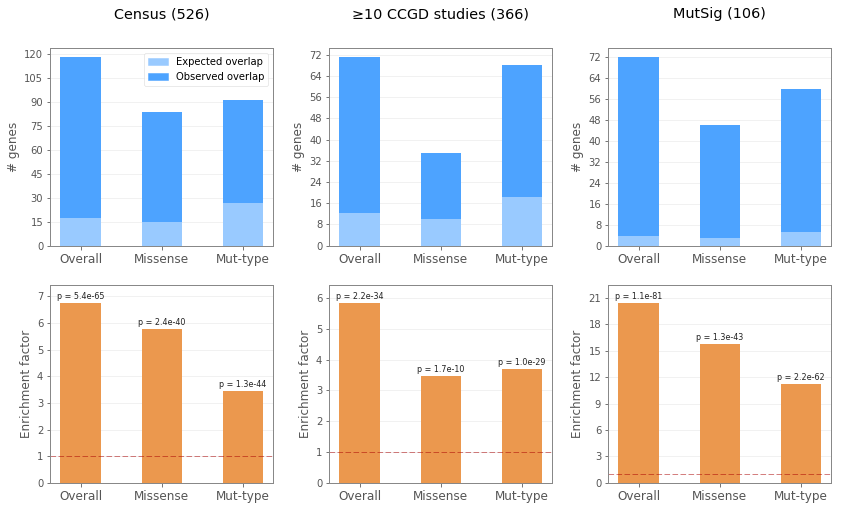

In [7]:
# Plotting encrichment

OUR_FLAGS = [
    ('alteration_promoting_by_overall_scores', 'Overall'),
    ('alteration_promoting_by_missense_scores', 'Missense'),
    ('alteration_promoting_by_types', 'Mut-type'),
]

OTHER_FLAGS = [
    ('census_any', 'Census'),
    ('ccgd_more_than_10_studies', '≥10 CCGD studies'.decode('utf8')),
    ('driver_by_mutsig', 'MutSig'),
]

TOP_PANEL_COLORS = ['#99caff', '#4da3ff']

our_flag_keys = zip(*OUR_FLAGS)[0]
pairwise_enrichment_results = pairwise_enrichment_results_per_project['combined']

fig, axes = plt.subplots(2, len(OTHER_FLAGS), figsize = (14, 8))

for i, (other_flag_key, other_flag_name) in enumerate(OTHER_FLAGS):
    
    # Obtain the values to plot for the ith column
    
    pairwise_enrichment_result = pairwise_enrichment_results.loc[our_flag_keys, other_flag_key]
    obs_values = pairwise_enrichment_result.apply(itemgetter('obs'))
    expected_values = pairwise_enrichment_result.apply(itemgetter('expected'))
    enrichment_values = pairwise_enrichment_result.apply(itemgetter('enrichment'))
    
    x_positions = np.arange(len(pairwise_enrichment_result))
    
    
    # Plot the upper-panel bar plot
    
    axes[0, i].bar(x_positions, obs_values, width = 0.5, facecolor = TOP_PANEL_COLORS[1])
    axes[0, i].bar(x_positions, expected_values, width = 0.5, facecolor = TOP_PANEL_COLORS[0])
    
    axes[0, i].set_ylabel('# genes')
    axes[0, i].set_title('%s (%d)' % (other_flag_name, cancer_results[other_flag_key].sum()), y = 1.12)

    if i == 0:
        axes[0, i].legend([Patch(color = color) for color in TOP_PANEL_COLORS], ['Expected overlap', 'Observed overlap'])
        
        
    # Plot the lower-panel bar plot
        
    axes[1, i].bar(x_positions, enrichment_values, width = 0.5, facecolor = '#EB984E')
    axes[1, i].axhline(y = 1, color = '#aa0000', linestyle = '--', linewidth = 0.5)

    y_lim_enrichment = 1.1 * enrichment_values.max()
    axes[1, i].set_ylim(0, y_lim_enrichment)
    axes[1, i].set_ylabel('Enrichment factor')

    for k, enrichment_result in enumerate(pairwise_enrichment_result):
        axes[1, i].text(k, enrichment_result['enrichment'] + y_lim_enrichment / 50, 'p = %.1e' % enrichment_result['pval'], \
                horizontalalignment = 'center', color = '#222222', fontsize = 8)

        
    # Set ticks and grid for both panels
        
    for j in range(2):
        axes[j, i].set_xticks(x_positions)
        axes[j, i].set_xticklabels([flag_name for flag_key, flag_name in OUR_FLAGS], fontsize = 12)
        axes[j, i].xaxis.grid(False)
        axes[j, i].yaxis.set_major_locator(MaxNLocator(integer=True))

fig.subplots_adjust(wspace = 0.25, hspace = 0.2)

In [ ]:
# Format diff.csv


# Parse diff values and p-values

diff_values = diff_results.loc[:, diff_project_columns].applymap(lambda raw_value: np.nan if pd.isnull(raw_value) else \
        json.loads(raw_value))
diff_pvals = diff_values.applymap(lambda value: value[1] if isinstance(value, list) else np.nan)
diff_pvals[~diff_prerequisite_mask] = np.nan


# Calculating q-values

diff_pvals_stacked = diff_pvals.stack()
_, diff_qvals = multipletests_with_nulls(diff_pvals_stacked)
diff_qvals = pd.Series(diff_qvals, index = diff_pvals_stacked.index).unstack()


# Formatting the complete diff dataframe

def format_diff_value(gene_index, project):
    
    value = diff_values.loc[gene_index, project]
        
    if isinstance(value, list):

        ci = value[0]
        qval = diff_qvals.loc[gene_index, project] if (gene_index in diff_qvals.index and project in diff_qvals.columns) \
                else np.nan

        if pd.notnull(qval):

            if qval <= 0.05:
                significance_label = ' (*)'
            else:
                significance_label = ''

            return '%.2f - %.2f / %e%s' % (tuple(ci) + (qval, significance_label))
        else:
            if diff_prerequisite_mask.loc[gene_index, project]:
                return '%.2f - %.2f' % tuple(ci)
            else:
                return '%.2f - %.2f (-)' % tuple(ci)
    else:
        return '-'
            
formatted_diff = pd.DataFrame(index = diff_results.index, columns = diff_results.columns)
formatted_diff.iloc[:, :7] = diff_results.iloc[:, :7]

for gene_index in diff_results.index:
    for project in diff_project_columns:
        formatted_diff.loc[gene_index, project] = format_diff_value(gene_index, project)  
        
        
# Sorting genes.

# For each gene, we consider only the significant (q-value <= 0.05) cancer types, or, if none is significant (as is the case
# for most genes), then we consider those with the lowest p-value. Then among only those cancer types we consider
# (usually only one), we will take the lowest strength to be the strength of the gene.
        
def get_ci_strength(ci):
    if len(set(map(np.sign, ci))) == 1:
        return min(map(abs, ci))
    else:
        return 0

pvals = diff_values.applymap(lambda value: value[1] if isinstance(value, list) else np.nan)
non_significance_mask = (diff_qvals.fillna(1) > 0.05).reindex(index = diff_values.index, columns = diff_values.columns, \
        fill_value = True)
significance_score = pvals.where(non_significance_mask, other = 0)
min_significance_score = significance_score.min(axis = 1)
formatted_diff['significance'] = 1 - min_significance_score

strength = diff_values.applymap(lambda value: get_ci_strength(value[0]) if isinstance(value, list) else np.nan)
strength_mask = significance_score.apply(lambda column: column == min_significance_score)
formatted_diff['strength'] = strength.where(strength_mask, other = np.nan).max(axis = 1)

formatted_diff.sort_values(['significance', 'strength'], ascending = False, inplace = True)
del formatted_diff['significance'], formatted_diff['strength']


# Sorting columns

first_columns = formatted_diff.columns[:7]
project_columns = formatted_diff.columns[7:]
formatted_diff = formatted_diff.reindex(columns = list(first_columns) + sorted(project_columns))


# Output CSV file

formatted_diff.to_csv(os.path.join(COMPLETE_RESULTS_DIR, 'diff.csv'))
print('Done.')

## Finish project (cancer-type) summary table

In [8]:
diff = pd.read_csv(os.path.join(DATA_DIR, 'gdc_results_complete/diff.csv'), index_col = 0)

def count_alteration_promoting_genes(project):
    results = pd.read_csv(os.path.join(DATA_DIR, 'gdc_results_complete/%s.csv' % project), index_col = 0)
    return results['alteration_promoting_by_overall_scores'].sum()

project_summaries['n_significant_alteration_promoting'] = project_summaries['tcga_project'].apply(\
        count_alteration_promoting_genes)
project_summaries['n_significant_diffs'] = project_summaries['tcga_project'].apply(lambda project: \
        diff[project].str.contains('(*)', regex = False).sum())

display(project_summaries)

print('Sum:')
project_summaries[['n_significant_alteration_promoting', 'n_significant_diffs']].sum()

,tcga_project,primary_site,disease,total_tcga_seqed_samples,n_samples,n_mutations,mean_mutations_per_sample,std_mutations_per_sample,n_significant_alteration_promoting,n_significant_diffs
0,BRCA,Breast,Breast Invasive Carcinoma,1098,986,120988,122.705882,347.775315,12,6
1,LUAD,Lung,Lung Adenocarcinoma,582,567,208180,367.160494,386.347251,14,5
2,UCEC,Uterus,Uterine Corpus Endometrial Carcinoma,559,530,886377,1672.409434,4159.661392,146,24
3,HNSC,Head and Neck,Head and Neck Squamous Cell Carcinoma,528,508,102309,201.395669,288.087653,15,7
4,LGG,Brain,Brain Lower Grade Glioma,516,508,35556,69.992126,635.728218,9,3
5,PRAD,Prostate,Prostate Adenocarcinoma,498,495,29286,59.163636,408.267664,3,0
6,LUSC,Lung,Lung Squamous Cell Carcinoma,504,492,181116,368.121951,317.639745,12,2
7,THCA,Thyroid,Thyroid Carcinoma,507,492,10899,22.152439,52.296615,4,1
8,SKCM,Skin,Skin Cutaneous Melanoma,470,467,392571,840.623126,1423.392934,16,11
9,STAD,Stomach,Stomach Adenocarcinoma,443,437,213144,487.743707,929.349515,10,1


Sum:


n_significant_alteration_promoting    380
n_significant_diffs                    92
dtype: int64

In [9]:
# Count unique alteration promoting genes across cancer types

signfiicant_genes_in_cancer_types = defaultdict(list)

for project in project_summaries['tcga_project']:
    
    results = pd.read_csv(os.path.join(DATA_DIR, 'gdc_results_complete/%s.csv' % project), index_col = 0)
    
    for gene in results.loc[results['alteration_promoting_by_overall_scores'], 'symbol']:
        signfiicant_genes_in_cancer_types[gene].append(project)
        
print('There are %d unique alteration promoting genes across cancer types.' % len(signfiicant_genes_in_cancer_types))

There are 231 unique alteration promoting genes across cancer types.


## Finding overlooked results

In [10]:
def parse_max_int(string):
    return max(map(int, re.findall(r'\d+', string)))

cancer_results['ccgd_annotations'] = cancer_results['ccgd_annotations'].apply(lambda raw_annotations: eval(raw_annotations) if \
        isinstance(raw_annotations, str) else raw_annotations)
n_ccgd_studies = cancer_results['ccgd_annotations'].apply(lambda annotations: 0 if pd.isnull(annotations) else \
        parse_max_int(annotations['studies']))

rank = pd.Series(range(1, len(cancer_results) + 1), index = cancer_results.index).rename('rank').to_frame()
overlooked_mask = cancer_results['alteration_promoting_by_overall_scores'] & (~cancer_results['census_any']) & \
        (n_ccgd_studies == 0)
overlooked_cancer_results = pd.concat([rank, cancer_results], axis = 1).loc[overlooked_mask]
very_significant_overlooked_cancer_results = overlooked_cancer_results[overlooked_cancer_results['overall_fdr_qval'] <= 0.001]

print('Found %d overlooked alteration promoting genes, %d of which are very significant.' % \
        (len(overlooked_cancer_results), len(very_significant_overlooked_cancer_results)))
display(very_significant_overlooked_cancer_results[['rank', 'symbol', 'name', 'chr', 'n_obs', 'mutations_per_nt', \
        'overall_z_value', 'overall_fdr_qval']])

Found 183 overlooked alteration promoting genes, 26 of which are very significant.


,rank,symbol,name,chr,n_obs,mutations_per_nt,overall_z_value,overall_fdr_qval
4684,54,GRM5,glutamate metabotropic receptor 5,11,441.0,0.121287,-0.310784,2.793342e-08
13844,61,USP28,ubiquitin specific peptidase 28,11,240.0,0.074280,-0.427532,1.544298e-07
10278,63,MICU3,mitochondrial calcium uptake family member 3,8,88.0,0.055346,-0.636601,3.948536e-07
7691,69,ZNF750,zinc finger protein 750,17,174.0,0.080221,-0.506104,2.142588e-06
2819,71,PGR,progesterone receptor,11,215.0,0.076813,-0.406829,2.580525e-06
3626,72,ZNF14,zinc finger protein 14,19,160.0,0.083074,-0.470481,2.903932e-06
6037,82,HOXA4,homeobox A4,7,55.0,0.057292,-0.806843,8.744701e-06
364,84,WTIP,Wilms tumor 1 interacting protein,19,46.0,0.035659,-0.844135,9.642809e-06
4595,93,CDKN1A,cyclin dependent kinase inhibitor 1A,6,69.0,0.140244,-0.629223,4.083830e-05
5926,94,ELF3,E74 like ETS transcription factor 3,1,108.0,0.097035,-0.488106,5.238828e-05


In [ ]:
# Saving the overlooked results.
overlooked_cancer_results.to_csv(os.path.join(DATA_DIR, 'gdc_overlooked_results.csv'))

## Heatmaps of genes across cancer types

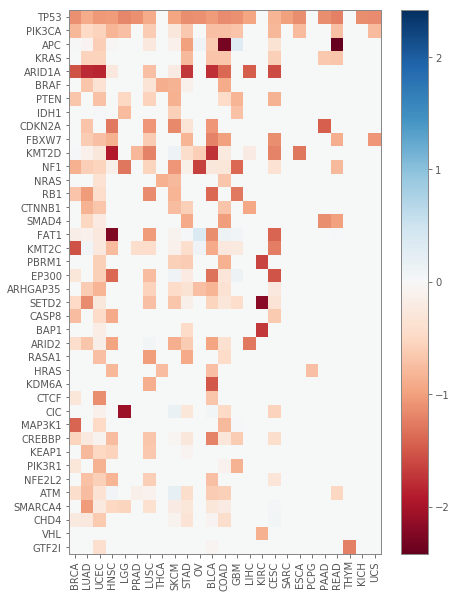

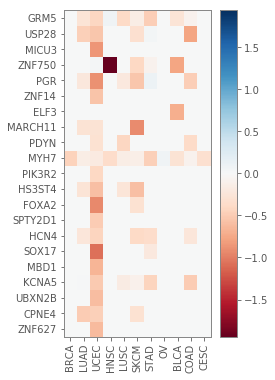

In [11]:
# Heatmaps of z-values across cancer types

def get_z_values_across_cancer_types(gene_indices, min_obs = 15):
    
    z_values_across_cancer_types = pd.DataFrame(index = gene_indices)
    
    for project in project_summaries['tcga_project']:
        results = pd.read_csv(os.path.join(DATA_DIR, 'gdc_results_complete/%s.csv' % project), index_col = 0)
        z_values_across_cancer_types[project] = results.loc[gene_indices, 'overall_z_value'].where(\
                results.loc[gene_indices, 'n_obs'] >= min_obs)
        
    return z_values_across_cancer_types.loc[:, ~pd.isnull(z_values_across_cancer_types).all()]

# z-values of 40 top genes
z_values_across_cancer_types_of_top_alteration_promoting_genes = get_z_values_across_cancer_types(\
        cancer_results.index[:40].tolist())
draw_heat_map(z_values_across_cancer_types_of_top_alteration_promoting_genes, figsize = (7, 10), row_labels = \
        cancer_results.loc[z_values_across_cancer_types_of_top_alteration_promoting_genes.index, 'symbol'])

# z-values of very significant overlooked genes
z_values_across_cancer_types_of_overlooked_alteration_promoting_genes = get_z_values_across_cancer_types(\
        very_significant_overlooked_cancer_results.index.tolist())
z_values_across_cancer_types_of_overlooked_alteration_promoting_genes = \
        z_values_across_cancer_types_of_overlooked_alteration_promoting_genes[\
                ~pd.isnull(z_values_across_cancer_types_of_overlooked_alteration_promoting_genes).all(axis = 1)]
draw_heat_map(z_values_across_cancer_types_of_overlooked_alteration_promoting_genes, figsize = (3.3, 6), row_labels = \
        cancer_results.loc[z_values_across_cancer_types_of_overlooked_alteration_promoting_genes.index, 'symbol'])

There are overall 92 significant <gene & cancer-type> combintations, involving 68 unique genes across 17 cancer types.


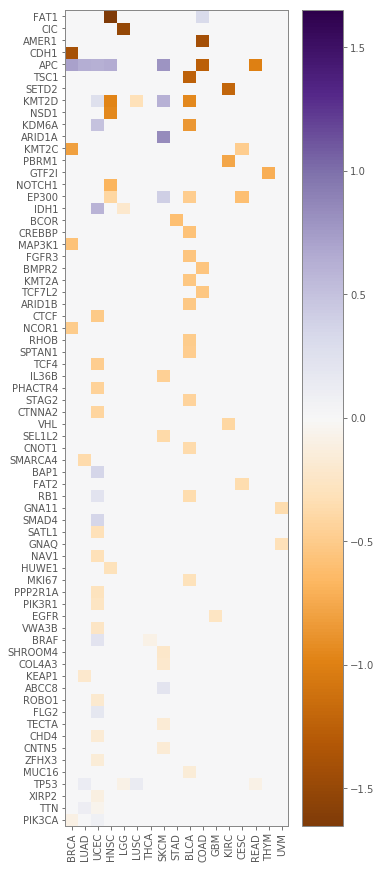

In [12]:
# Heatmap of significant differences across cancer types

CI_REGEX = re.compile(r'(-?[\d\.]+) - (-?[\d\.]+)')

def parse_significant_diff_lower_bound(formatted_value):
    
    if pd.isnull(formatted_value) or '(*)' not in formatted_value:
        return 0
    
    ci, = CI_REGEX.findall(formatted_value)
    ci = map(float, ci)
    ci_signs = set(map(np.sign, ci))
    
    if len(ci_signs) == 1:
        ci_sign, = ci_signs
        return ci_sign * min(map(abs, ci))
    else:
        return 0
    
diff_results = pd.read_csv(os.path.join(DATA_DIR, 'gdc_results_complete/diff.csv'), index_col = 0)
significant_diff_lower_bounds = diff_results.iloc[:, 7:].applymap(parse_significant_diff_lower_bound)
significant_diff_lower_bounds = significant_diff_lower_bounds[project_summaries['tcga_project']]
significant_diff_lower_bounds = significant_diff_lower_bounds.loc[(significant_diff_lower_bounds != 0).any(axis = 1), \
        (significant_diff_lower_bounds != 0).any()]

print(('There are overall %d significant <gene & cancer-type> combintations, involving %d unique genes across %d ' + \
        'cancer types.') % (((significant_diff_lower_bounds != 0).sum().sum(),) + significant_diff_lower_bounds.shape))
draw_heat_map(significant_diff_lower_bounds, figsize = (5, 15), cmap = 'PuOr', row_labels = \
        cancer_results.loc[significant_diff_lower_bounds.index, 'symbol'])

## TP53 illustration

In [13]:
from fabric import Setup

setup = Setup('GRCh38', gene_dataset_dir = FABRIC_DATA_DIR)

tp53_gene, = [gene for gene in setup.geneffect_setup.genes if gene.symbol == 'TP53']
print(tp53_gene)

GENEFFECT|PID-46732 [2017-12-23 19:14:58.644780]: Working with reference genome version GRCh38 (user specified: GRCh38).
GENEFFECT|PID-46732 [2017-12-23 19:14:59.824113]: Loaded 93748 pfam records, 51710 of which are domains. Found 347 unique clans within these domains, 173 of which are common (with at least 25 occurrences).
GENEFFECT|PID-46732 [2017-12-23 19:16:28.255794]: Parsed 20168 UniProt records.
GENEFFECT|PID-46732 [2017-12-23 19:17:13.090864]: Loaded 2604486 gene annotations.
GENEFFECT|PID-46732 [2017-12-23 19:17:14.084827]: Loaded 20080 gene meta data records.
GENEFFECT|PID-46732 [2017-12-23 19:17:16.838655]: Constructed 707004 CDS records.


/cs/proto_nadavb/my_python/local/lib/python2.7/site-packages/Bio/Seq.py:2095: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


GENEFFECT|PID-46732 [2017-12-23 19:20:51.092402]: Parsed 18052 genes.
GENEFFECT|PID-46732 [2017-12-23 19:20:52.620342]: Finished setting up reference genome GRCh38.
FABRIC|PID-46732 [2017-12-23 19:20:56.758458]: The 18052 genes in the created gene dataset are identical to the ones in the existing CSV file: /cs/phd/nadavb/github_projects/fabric/data/genes_GRCh38.csv
<Gene: TP53, P04637 / <CDSIsoform: ENST00000269305.8 (chr17 (-), 10 CDS exons)>>


### Draw the CDS exons and introns of TP53

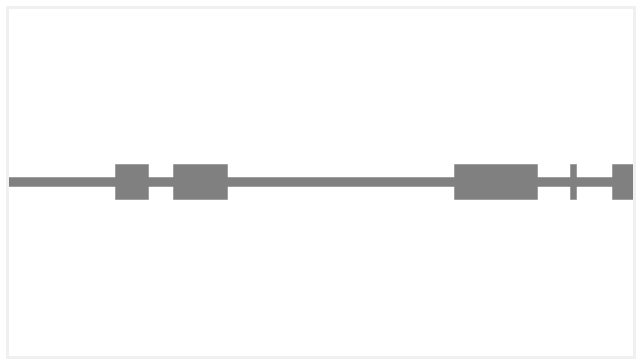

In [14]:
exon_coordinates = [(exon.chromosome_start, exon.chromosome_end) for exon in tp53_gene.canonical_cds_isoform.cds_exons]
flat_coordinates = np.array(exon_coordinates).flatten()

min_coordinate = flat_coordinates.min()
max_coordinate = flat_coordinates.max()

def to_gene_relative_coordinate(absolute_coordinate):
    return (absolute_coordinate - min_coordinate) / (max_coordinate - min_coordinate)

def draw_rectangle(ax, start_x, end_x, start_y, end_y):
    ax.add_patch(patches.Rectangle((start_x, start_y), end_x - start_x, end_y - start_y, color = 'gray'))
    
with plt.style.context('fivethirtyeight'):
    
    fig, ax = plt.subplots(figsize = (10, 6))
    draw_rectangle(ax, 0, 1, -0.1, 0.1)
    
    for start, end in exon_coordinates:
        draw_rectangle(ax, to_gene_relative_coordinate(start), to_gene_relative_coordinate(end), -0.4, 0.4)

    ax.set_xlim(0.7, 1) # Zoom into the last 30% of the gene
    ax.set_ylim(-4, 4)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_facecolor('white')
    fig.set_facecolor('white')

### Analyze specific chosen SNPs within TP53

In [15]:
from fabric.set_gene_bg_scores import _GeneAnalysis

def create_all_possible_gene_effects(gene):
    gene_analysis = _GeneAnalysis(gene, None, None)
    gene_analysis._create_all_possible_gene_effects()
    return {substitution: substitution_analysis.gene_effects for substitution, substitution_analysis in \
            gene_analysis.substitution_analyses.items()}

tp53_gene_effects = create_all_possible_gene_effects(tp53_gene)
tp53_flat_gene_effects = [gene_effect for substitution_gene_effects in tp53_gene_effects.values() for gene_effect in \
        substitution_gene_effects]
print('Constructed all possible %d gene effects for gene %s.' % (len(tp53_flat_gene_effects), tp53_gene.symbol))

Constructed all possible 3537 gene effects for gene TP53.


/cs/proto_nadavb/my_python/local/lib/python2.7/site-packages/Bio/Seq.py:152: BiopythonWarning: Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.
  "the new string hashing behaviour.", BiopythonWarning)


In [16]:
from fabric import calc_effect_scores_of_gene_effects

CHOSEN_SNPS = ['P36S', 'L194P', 'M243L', 'L344L', 'K357*']
N_CONTEXT = 4

def get_gene_effect(gene_effect_suffix):
    for gene_effect in tp53_flat_gene_effects:
        if str(gene_effect).endswith(gene_effect_suffix):
            return gene_effect

gene_effects = map(get_gene_effect, CHOSEN_SNPS)
effect_scores = calc_effect_scores_of_gene_effects(gene_effects, setup)

for gene_effect, effect_score in zip(gene_effects, effect_scores):
    old_seq = tp53_gene.uniprot_record.seq[(gene_effect.protein_coordinate - N_CONTEXT - 1):(gene_effect.protein_coordinate + \
            N_CONTEXT)]
    assert old_seq[N_CONTEXT] == gene_effect.ref_aa
    new_seq = old_seq[:N_CONTEXT] + gene_effect.alt_aa + old_seq[(N_CONTEXT + 1):]
    print('%s: %s --> %s (%.3f)' % (gene_effect, old_seq, new_seq, effect_score))

FABRIC|PID-46732 [2017-12-23 19:24:18.472592]: Applying FIRM classifier on 3 missense mutations...
P04637:P36S: LSPLPSQAM --> LSPLSSQAM (0.633)
P04637:L194P: PPQHLIRVE --> PPQHPIRVE (0.005)
P04637:M243L: NSSCMGGMN --> NSSCLGGMN (0.028)
P04637:L344L: MFRELNEAL --> MFRELNEAL (1.000)
P04637:K357*: AQAGKEPGG --> AQAG*EPGG (0.000)


z-values:
0.34, -1.15, -1.10, 1.23, -1.17


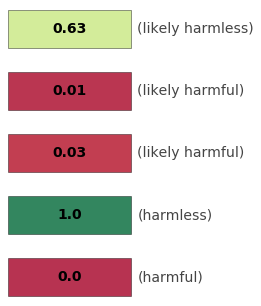

In [17]:
# Visualize scores

SCORES = np.array([0.63, 0.01, 0.03, 1, 0])
BG_MEAN = 0.488
BG_STD = 0.416

def get_interpretation(score):
    if score == 0:
        return 'harmful'
    elif score == 1:
        return 'harmless'
    elif score < 0.5:
        return 'likely harmful'
    else:
        return 'likely harmless'

def draw_rectangle(ax, start_x, end_x, start_y, end_y, **kwargs):
    ax.add_patch(patches.Rectangle((start_x, start_y), end_x - start_x, end_y - start_y, **kwargs))

with plt.style.context('fivethirtyeight'):
    
    fig, ax = plt.subplots(figsize = (2, 5))
    cmap = mpl.cm.get_cmap('RdYlGn')
    
    for i, score in enumerate(reversed(SCORES)):
        draw_rectangle(ax, 0, 1, i - 0.3, i + 0.3, facecolor = cmap(score), edgecolor = 'black', alpha = 0.8)
        ax.text(0.5, i, str(score), horizontalalignment = 'center', verticalalignment = 'center', fontweight = 'bold')
        ax.text(1.05, i, '(%s)' % get_interpretation(score), verticalalignment = 'center', color = '#444444')
    
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.35, len(SCORES) - 1 + 0.35)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    ax.set_facecolor('white')
    fig.set_facecolor('white')

z_values = (SCORES - BG_MEAN) / BG_STD
print('z-values:')
print(', '.join(['%.2f' % value for value in z_values]))

### Plot P53's substitutions frequencies and background distributions

In [18]:
from fabric import load_effect_scores_series
from fabric.maf_mutation_loader import load_relevant_mutations

all_mutations = load_relevant_mutations(os.path.join(DATA_DIR, 'gdc_combined.maf'))
all_mutations['effect_scores'] = load_effect_scores_series(os.path.join(DATA_DIR, 'gdc_effect_scores.csv'))

tp53_gene_index = setup.gene_dataset.loc[setup.gene_dataset['symbol'] == tp53_gene.symbol].iloc[0].name
%time tp53_mutations = pd.DataFrame([pd.concat([mutation[['Tumor_Seq_Allele1', 'Tumor_Seq_Allele2']], \
        pd.Series([effect_score], index = ['effect_score'])]) for _, mutation in all_mutations.iterrows() for \
        gene_index, effect_score in mutation['effect_scores'].items() if gene_index == tp53_gene_index])

del all_mutations
summarize(tp53_mutations)

/cs/proto_nadavb/my_python/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (19,20,28,87,88,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


FABRIC|PID-46732 [2017-12-23 19:25:33.812768]: Loaded 3175929 MAF records.
FABRIC|PID-46732 [2017-12-23 19:25:36.623858]: Filtered 2956550 of 3175929 (93%) relevant mutations (SNPs).
CPU times: user 3min 51s, sys: 2.69 s, total: 3min 54s
Wall time: 3min 54s


,Tumor_Seq_Allele1,Tumor_Seq_Allele2,effect_score
0,C,A,0.022698
1,C,A,0.015385
2,T,G,0.039643
3,A,T,0.018046
4,C,T,0.018923


3167 records


In [19]:
tp53_substitution_counts = tp53_mutations.groupby(['Tumor_Seq_Allele1', 'Tumor_Seq_Allele2']).size().unstack().fillna(0)\
        .rename_axis(None, axis = 0).rename_axis(None, axis = 1)
tp53_substitution_freqs = tp53_substitution_counts / tp53_substitution_counts.sum().sum()
display(tp53_substitution_freqs)

,A,C,G,T
A,0.000000,0.033154,0.029365,0.021156
C,0.170824,0.000000,0.041996,0.249763
G,0.252921,0.038522,0.000000,0.028418
T,0.026524,0.095674,0.011683,0.000000


In [20]:
from fabric.gene_score_dist import GeneScoreModel

tp53_bg_file_path = os.path.join(FABRIC_DATA_DIR, 'gene_bg_scores', setup.geneffect_setup._config_setup.ref_genome, \
        '%s.json' % tp53_gene.uniprot_record.id)

with open(tp53_bg_file_path, 'r') as f:
    tp53_bg_model = GeneScoreModel(json.load(f))
    
def draw_distribution(ax, dist, show_statistics = True, sample_size = 10000, bw_method = None, total_area = 1, \
        plot_kwargs = {}):
    
    values = dist.sample(sample_size)
    x = np.linspace(0, 1, 100)
    y = total_area * gaussian_kde(values, bw_method)(x)
    
    dist_plot, = ax.plot(x, y, **plot_kwargs)
    
    if show_statistics:
        ax.text(0.5, 0.95 * y.max(), 'μ = %.2f, σ = %.2f'.decode('utf8') % (dist.mean(), dist.std()), \
                fontsize = 20, horizontalalignment = 'center')
    
    if total_area == 1:
        ax.get_yaxis().set_visible(False)
    
    ax.set_xlim(0, 1)
    ax.set_facecolor('white')
    
    return dist_plot

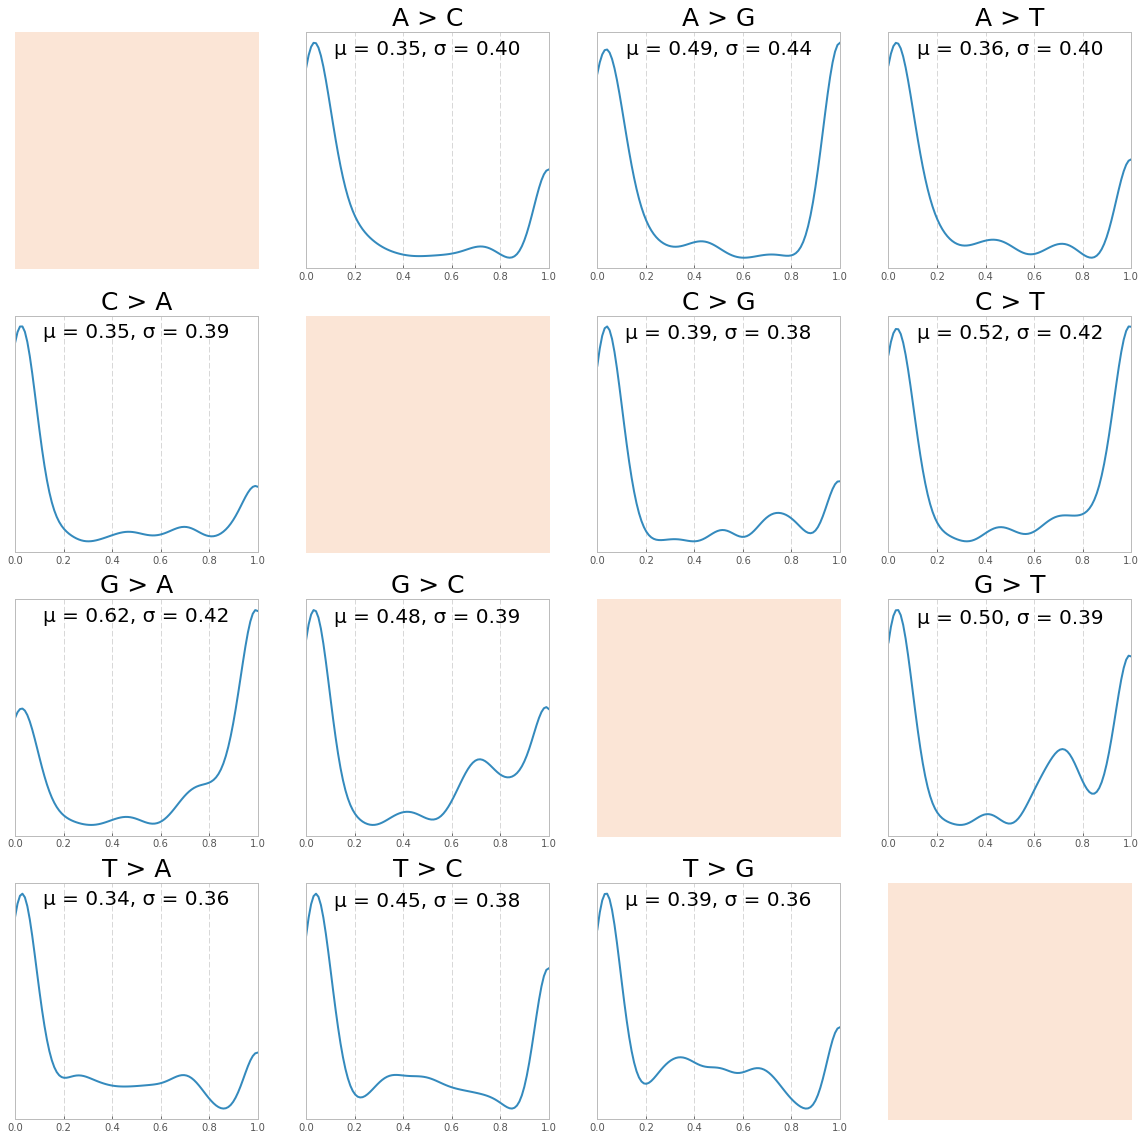

In [21]:
from fabric.util import ALL_NTS_LIST

with plt.style.context('bmh'):
    
    fig, axes = plt.subplots(4, 4, figsize = (20, 20))

    for i in range(4):
        for j in range(4):
            if i == j:
                axes[i, j].get_xaxis().set_visible(False)
                axes[i, j].get_yaxis().set_visible(False)
                axes[i, j].set_facecolor('#fbe5d6')
                plt.setp(axes[i, j].spines.values(), color = '#fbe5d6')
            else:
                ref_nt = ALL_NTS_LIST[i]
                alt_nt = ALL_NTS_LIST[j]
                draw_distribution(axes[i, j], tp53_bg_model.substitution_score_distributions[(ref_nt, alt_nt)])
                axes[i, j].set_title('%s > %s' % (ref_nt, alt_nt), fontsize = 25)

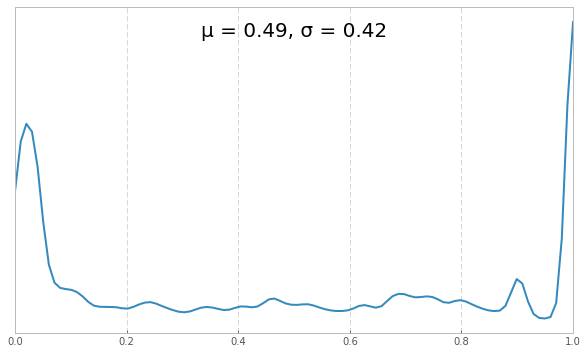

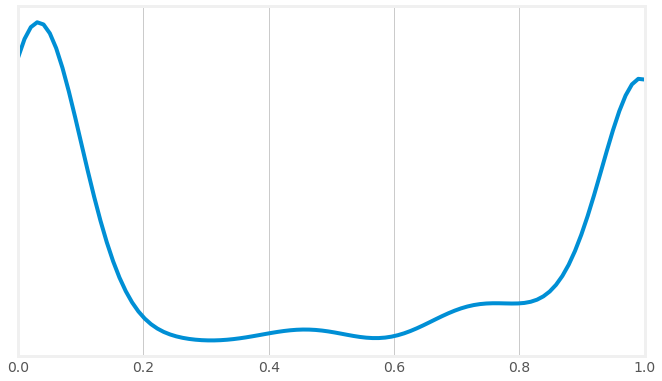

In [22]:
from fabric.gene_score_dist import get_gene_score_distribution

tp53_bg_dist = get_gene_score_distribution(tp53_bg_model, tp53_substitution_counts)

with plt.style.context('bmh'):
    fig, ax = plt.subplots(figsize = (10, 6))
    draw_distribution(ax, tp53_bg_dist, bw_method = 0.03)
    
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize = (10, 6))
    draw_distribution(ax, tp53_bg_dist, show_statistics = False)
    fig.set_facecolor('white')

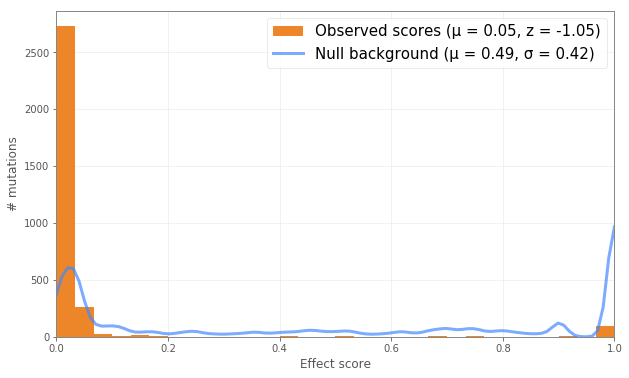

In [23]:
BINS = 30

observed_scores = tp53_mutations['effect_score']
mean_observed_scores = observed_scores.mean()
mean_observed_z_value = (mean_observed_scores - tp53_bg_dist.mean()) / tp53_bg_dist.std()

fig, ax = plt.subplots(figsize = (10, 6))

_, _, hist_plot = ax.hist(observed_scores, bins = BINS, color = '#ec7912', alpha = 0.9)
dist_plot = draw_distribution(ax, tp53_bg_dist, show_statistics = False, total_area = \
        len(observed_scores) / BINS, bw_method = 0.03, plot_kwargs = {'color': '#4488ff', 'linewidth': 3, 'alpha': 0.7})

ax.set_xlabel('Effect score')
ax.set_ylabel('# mutations')

ax.legend([hist_plot[0], dist_plot], ['Observed scores (μ = %.2f, z = %.2f)'.decode('utf8') % (mean_observed_scores, \
        mean_observed_z_value), 'Null background (μ = %.2f, σ = %.2f)'.decode('utf8') % \
        (tp53_bg_dist.mean(), tp53_bg_dist.std())], fontsize = 15)

### Illustration of normal-distribution two-tailed p-value

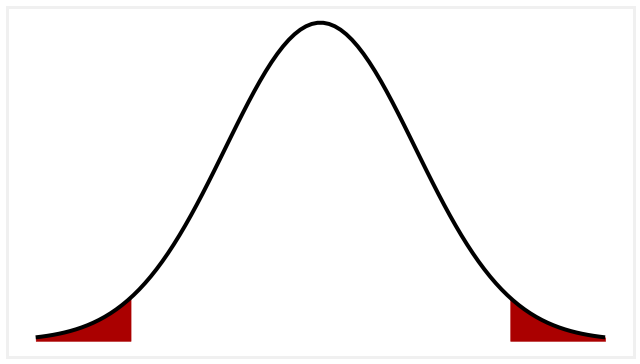

In [24]:
with plt.style.context('fivethirtyeight'):
    
    fig, ax = plt.subplots(figsize = (10, 6))
    
    x = np.linspace(-3, 3, 100)
    ax.plot(x, norm.pdf(x, 0, 1), color = 'black')
    
    x = np.linspace(2, 3, 10)
    ax.fill_between(x, 0, norm.pdf(x, 0, 1), color = '#aa0000')
    
    x = np.linspace(-3, -2, 10)
    ax.fill_between(x, 0, norm.pdf(x, 0, 1), color = '#aa0000')
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_facecolor('white')
    fig.set_facecolor('white')

# ExAC Analysis

## Analyze AF vs. z-value

This depends on the exac_variants.csv file, created by the following command:

create_vcf_dataset --reference-genome=hg19 --gene-dataset-dir=~/fabric_data/ --vcf-file=~/tcga_and_exac_analysis/ExAC.r1.sites.vep.vcf.gz --output-csv-file=~/tcga_and_exac_analysis/exac_variants.csv --only-pass

(follow the instructions in the README file in the repository)

In [25]:
# Prepare hg19 gene score models

from fabric.gene_score_dist import GeneScoreModel

def parse_gene_score_model(uniprot_id, ref_genome):
    with open(os.path.join(FABRIC_DATA_DIR, 'gene_bg_scores', ref_genome, '%s.json' % uniprot_id), 'r') as f:
        return GeneScoreModel(json.load(f))

hg19_genes = pd.read_csv(os.path.join(FABRIC_DATA_DIR, 'genes_hg19.csv'), index_col = 0)

%time gene_score_models_hg19 = {gene_index: parse_gene_score_model(uniprot_id, 'hg19') for \
        gene_index, uniprot_id in hg19_genes['uniprot_id'].iteritems()}

CPU times: user 27.3 s, sys: 811 ms, total: 28.1 s
Wall time: 30.8 s


In [26]:
# Load ExAC variants and calculate their z-values

dist_statistics_cache = {}

def get_dist_statistics(gene_index, substitution):
    
    cache_key = (gene_index, substitution)
    
    if cache_key not in dist_statistics_cache:
        substitution_dist = gene_score_models_hg19[gene_index].substitution_score_distributions[substitution]
        dist_statistics_cache[cache_key] = (substitution_dist.mean(), substitution_dist.std())
        
    return dist_statistics_cache[cache_key]

def get_z_value(gene_index, substitution, score):
    bg_mean, bg_std = get_dist_statistics(gene_index, substitution)
    return (score - bg_mean) / bg_std

def get_z_values(variant_record):
    substitution = (variant_record['ref'], variant_record['alt'])
    return {gene_index: get_z_value(gene_index, substitution, score) for gene_index, score in \
            variant_record['effect_scores'].items()}

%time exac_variants = pd.read_csv(os.path.join(DATA_DIR, 'exac_variants.csv'))
%time exac_variants['effect_scores'] = exac_variants['effect_scores'].apply(eval)
%time exac_variants['z_values'] = exac_variants.apply(get_z_values, axis = 1)

summarize(exac_variants, 20)

<string>:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 7.56 s, sys: 463 ms, total: 8.02 s
Wall time: 8.02 s
CPU times: user 46 s, sys: 1.45 s, total: 47.5 s
Wall time: 45 s
CPU times: user 6min 56s, sys: 1.89 s, total: 6min 58s
Wall time: 6min 58s


,id,chrom,pos,ref,alt,AF,qual,filter,effect_scores,z_values
0,.,1,13372,G,C,0.000070,608.91,PASS,{},{}
1,.,1,13494,A,G,0.000945,18163.42,PASS,{},{}
2,.,1,13504,G,A,0.001359,6229.58,PASS,{},{}
3,.,1,13539,G,C,0.000477,658.19,PASS,{},{}
4,.,1,17407,G,A,0.034000,137942.94,PASS,{},{}
5,.,1,17408,C,G,0.016000,49135.65,PASS,{},{}
6,.,1,17452,C,T,0.016000,309992.01,PASS,{},{}
7,.,1,17453,G,A,0.000331,1862.32,PASS,{},{}
8,.,1,17459,T,C,0.000012,489.49,PASS,{},{}
9,.,1,17462,G,A,0.000012,184.62,PASS,{},{}


8538742 records


In [27]:
n_scores_per_variant = exac_variants['effect_scores'].apply(len)
print('There are %d effect scores in %d variants.' % (n_scores_per_variant.sum(), (n_scores_per_variant > 0).sum()))

There are 4752768 effect scores in 4747096 variants.


In [28]:
%time afs_and_zvals = [(variant_record['AF'], z_value) for _, variant_record in exac_variants.iterrows() for z_value in \
        variant_record['z_values'].values()]
afs, z_values = map(np.array, zip(*afs_and_zvals))

print('Spearman\'s correlation between AF to z-value:')
print(spearmanr(afs, z_values))

CPU times: user 10min 49s, sys: 1.45 s, total: 10min 50s
Wall time: 10min 49s
Spearman's correlation between AF to z-value:
SpearmanrResult(correlation=0.051431451915262688, pvalue=0.0)


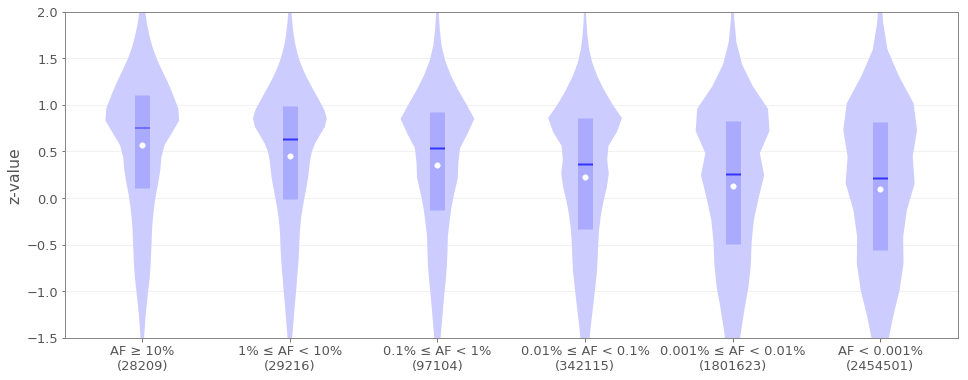

In [29]:
# Draw violin plots of z-values in different AF bins.

AF_BIN_THRESHOLDS = [(1e-1, '10%'), (1e-2, '1%'), (1e-3, '0.1%'), (1e-4, '0.01%'), (1e-5, '0.001%')]

AF_bin_threshold_values, AF_bin_threshold_labels = zip(*AF_BIN_THRESHOLDS)
z_values_per_bin = [z_values[afs >= AF_bin_threshold_values[0]]] + [z_values[(afs < AF_bin_threshold_values[i]) & \
        (afs >= AF_bin_threshold_values[i + 1])] for i in range(len(AF_bin_threshold_values) - 1)] + \
        [z_values[afs < AF_bin_threshold_values[-1]]]
bin_labels = ['AF ≥ %s' % AF_bin_threshold_labels[0]] + ['%s ≤ AF < %s' % (AF_bin_threshold_labels[i + 1], \
        AF_bin_threshold_labels[i]) for i in range(len(AF_bin_threshold_labels) - 1)] + ['AF < %s' % AF_bin_threshold_labels[-1]]

with mpl.rc_context(rc = {'font.size': 13}):
    
    fig, ax = plt.subplots(figsize = (16, 6))
    x = np.arange(1, len(z_values_per_bin) + 1)
    
    # Draw the violins
    violin_plots = ax.violinplot(z_values_per_bin, showextrema = False)

    # Draw the boxes
    means = map(np.mean, z_values_per_bin)
    q1, q2, q3 = map(np.array, zip(*[np.percentile(bin_z_values, [25, 50, 75]) for bin_z_values in z_values_per_bin]))
    ax.vlines(x, q1, q3, color = '#aaaaff', linestyle = '-', lw = 15)
    ax.vlines(x, q2 - 0.01, q2 + 0.01, color = '#3333ff', linestyle = '-', lw = 15)
    ax.scatter(x, means, marker = 'o', color = 'white', s = 30, zorder = 3)

    # Ticks, grids and labels
    ax.set_xticks(x)
    ax.set_xticklabels([bin_label.decode('utf8') + '\n(%d)' % len(bin_z_values) for bin_label, bin_z_values in \
            zip(bin_labels, z_values_per_bin)])
    ax.xaxis.grid(False)
    ax.set_ylim(-1.5, 2)
    ax.set_ylabel('z-value')

    for body in violin_plots['bodies']:
        body.set(facecolor = '#ccccff', alpha = 1) 

## Processing ExAC results

This section is a downstream analysis to the results obtained by FABRIC on the ExAC analysis, i.e. after running:

analyze_vcf_genes --reference-genome=hg19 --gene-dataset-dir=~/fabric_data/ --input-csv-file=~/tcga_and_exac_analysis/exac_variants.csv --gene-bg-scores-dir=~/fabric_data/gene_bg_scores/ --output-csv-file=~/tcga_and_exac_analysis/exac_results.csv

(follow the instructions in the README file in the repository)

In [30]:
# Parse exac_results.csv 

exac_results = pd.read_csv(os.path.join(DATA_DIR, 'exac_results.csv'), index_col = 0)
exac_results['observed_type_counts'] = exac_results['observed_type_counts'].apply(eval)
exac_results['expected_type_freqs'] = exac_results['expected_type_freqs'].apply(eval)


# Multiple testing and significance

exac_results['overall_fdr_significance'], exac_results['overall_fdr_qval'] = multipletests_with_nulls(\
        exac_results['overall_pval'])
exac_results['missense_fdr_significance'], exac_results['missense_fdr_qval'] = multipletests_with_nulls(\
        exac_results['missense_pval'])
exac_results['types_chi2_fdr_significance'], exac_results['types_chi2_fdr_qval'] = multipletests_with_nulls(\
        exac_results['types_chi2_pval'])

n_obs_total = exac_results['n_obs']
n_exp_synonymous = n_obs_total * exac_results['expected_type_freqs'].apply(itemgetter(0))
n_exp_missense = n_obs_total * exac_results['expected_type_freqs'].apply(itemgetter(1))
n_exp_nonsense = n_obs_total * exac_results['expected_type_freqs'].apply(itemgetter(2))
exac_results['types_significance'] = exac_results['types_chi2_fdr_significance'] & \
        (n_exp_synonymous >= 5) & (n_exp_missense >= 5) & (n_exp_nonsense >= 5)

    
# Sorting the results
    
exac_results['abs_overall_z_value'] = exac_results['overall_z_value'].abs()
exac_results.sort_values(['overall_fdr_qval', 'abs_overall_z_value'], ascending = [True, False], inplace = True)
del exac_results['abs_overall_z_value']


summarize(exac_results)

,uniprot_id,symbol,name,refseq_ids,chr,cds_start,cds_end,n_obs,cds_len,mutations_per_nt,overall_bg_mean,overall_bg_std,overall_observed_avg,overall_mean_deviation,overall_z_value,overall_pval,missense_bg_mean,missense_bg_std,missense_observed_avg,missense_mean_deviation,missense_z_value,missense_pval,types_chi2_pval,observed_type_counts,expected_type_freqs,overall_fdr_significance,overall_fdr_qval,missense_fdr_significance,missense_fdr_qval,types_chi2_fdr_significance,types_chi2_fdr_qval,types_significance
12454,Q8WZ42,TTN,titin,[u'NM_133378'],2,179391742,179669369,16039.0,103050.0,0.155643,0.937890,0.184601,0.965589,0.027699,0.150048,3.622952e-113,0.962470,0.036359,0.962853,0.000383,0.010533,2.311510e-01,4.313763e-84,"[4292, 11627, 120]","[0.269103341871, 0.694859297984, 0.0360373601446]",True,6.501749e-109,False,1.000000e+00,True,3.867073e-80,True
6826,Q14204,DYNC1H1,dynein cytoplasmic 1 heavy chain 1,[u'NM_001376'],14,102431029,102516897,1429.0,13938.0,0.102525,0.642458,0.303530,0.810776,0.168318,0.554536,2.630550e-105,0.503799,0.172994,0.558016,0.054217,0.313403,1.000000e+00,2.490427e-91,"[821, 605, 3]","[0.328366340855, 0.62527717781, 0.0463564813359]",True,2.360393e-101,False,1.000000e+00,True,4.465087e-87,True
8953,Q6P2Q9,PRPF8,pre-mRNA processing factor 8,[u'NM_006445'],17,1554099,1587865,745.0,7005.0,0.106353,0.628802,0.305328,0.827364,0.198562,0.650325,1.868646e-76,0.488609,0.157965,0.531526,0.042917,0.271686,1.000000e+00,8.370943e-74,"[475, 266, 4]","[0.32594417314, 0.625076794395, 0.0489790324645]",True,1.117824e-72,False,1.000000e+00,True,5.002755e-70,True
12598,Q92793,CREBBP,CREB binding protein,[u'NM_004380'],16,3777722,3929917,1101.0,7326.0,0.150287,0.754858,0.304679,0.900254,0.145396,0.477211,1.123222e-74,0.707127,0.257111,0.817415,0.110288,0.428953,8.429379e-30,4.585572e-39,"[504, 596, 1]","[0.294550135632, 0.652750195999, 0.0526996683687]",True,5.039336e-71,True,5.038521e-26,True,9.134969e-36,True
6315,Q09472,EP300,E1A binding protein p300,[u'NM_001429'],22,41489009,41574957,1152.0,7242.0,0.159072,0.763603,0.287327,0.897286,0.133684,0.465266,2.509565e-74,0.727445,0.236154,0.834764,0.107319,0.454445,1.378403e-39,9.811980e-28,"[446, 704, 2]","[0.266331946494, 0.685089837473, 0.0485782160336]",True,9.007330e-71,True,2.471752e-35,True,5.863966e-25,True


17946 records


In [31]:
# Count the number of significant genes

for column in exac_results.columns:
    if column.endswith('_significance'):
        print('%s: %d' % (column, exac_results[column].sum()))
        
significant_overall_z_values = exac_results.loc[exac_results['overall_fdr_significance'], 'overall_z_value']
print('In the overall analysis, %d genes are alteration promoting and %d are alteration rejecting.' % \
        ((significant_overall_z_values < 0).sum(), (significant_overall_z_values > 0).sum()))

overall_fdr_significance: 6288
missense_fdr_significance: 686
types_chi2_fdr_significance: 5486
types_significance: 4548
In the overall analysis, 147 genes are alteration promoting and 6141 are alteration rejecting.


In [ ]:
# Save the results.
exac_results.to_csv(os.path.join(DATA_DIR, 'exac_results_complete.csv'))

## Comparing ExAC z-values to external metrics (RVIS and GDI)

### RVIS

In [32]:
# Loading RVIS data

# Residual Variation Intolerance Score (RVIS): http://genic-intolerance.org/index.jsp
# The file can be downloaded from: http://genic-intolerance.org/data/GenicIntolerance_v3_12Mar16.txt
rvis_df = pd.read_csv(os.path.join(DATA_DIR, 'exac_external_metrics/GenicIntolerance_v3_12Mar16.txt'), delimiter = '\t')
summarize(rvis_df)

,GENE,ALL_0.01%,%ALL_0.01%,ALL_0.1%,%ALL_0.1%,ALL_1%,%ALL_1%,PP2_ALL_0.1%,%PP2_ALL_0.1%,EA_0.1%,%EA_0.1%,EA_1%,%EA_1%,AA_0.1%,%AA_0.1%,AA_1%,%AA_1%,OEratio,%OEratio,%ExAC_0.1%popn,%ExAC_0.05%popn,%ExAC_0.01%,OEratio-percentile[ExAC],LoF-FDR[ExAC]
0,A1BG,-0.35,29.49,-0.47,23.51,-0.01,48.78,-0.40,22.41,-0.10,47.36,0.00,59.84,-0.40,25.82,-0.29,33.93,NaN,NaN,14.77,18.29,35.25,76.144911,0.809581
1,A1CF,-0.29,33.48,-0.38,28.01,-1.31,5.96,-0.33,25.93,-0.81,12.54,-0.74,11.96,-0.52,21.12,-0.04,54.08,NaN,NaN,19.44,11.53,12.98,31.587389,0.009643
2,A2LD1,0.14,68.77,0.19,66.32,0.20,63.04,0.37,77.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A2M,-0.84,9.39,0.10,60.76,0.06,53.79,-0.87,8.89,-1.46,3.70,-0.57,17.28,1.17,92.81,-1.01,7.15,NaN,NaN,57.33,31.88,55.68,46.587389,0.000246
4,A2ML1,2.83,98.91,2.42,98.53,2.44,98.82,0.70,89.21,0.06,58.85,0.06,64.26,2.81,99.20,2.84,98.88,NaN,NaN,99.17,98.85,97.33,66.377212,0.455183


19093 records


In http://genic-intolerance.org/about.jsp they write:

A gene with a positive score has more common functional variation, and a gene with a negative score has less and is referred to as "intolerant". By convention we rank all genes in order from most intolerant to least. As an example, a gene such as ATP1A3 has a RVIS score of -1.53 and a percentile of 3.37%, meaning it is amongst the 3.37% most intolerant of human genes.

In [33]:
# Validating RVIS data
assert len(rvis_df['GENE'].unique()) == len(rvis_df)
symbol_to_rvis = dict(zip(rvis_df['GENE'], rvis_df.iloc[:, 3]))
assert symbol_to_rvis['ATP1A3'] == -1.53

# Comparing it with our z-values
z_values_and_rvis = pd.concat([exac_results['overall_z_value'], exac_results['symbol'].map(symbol_to_rvis).rename('rvis')], \
        axis = 1).dropna()
print('Matched %d genes with both z-values and RVIS.' % len(z_values_and_rvis))
print('Spearman\'s correlation:')
print(spearmanr(z_values_and_rvis['overall_z_value'], z_values_and_rvis['rvis']))

Matched 15545 genes with both z-values and RVIS.
Spearman's correlation:
SpearmanrResult(correlation=-0.3997689667989876, pvalue=0.0)


### GDI

In [34]:
# Loading GDI data

# Human Gene Damage Index (GDI): http://lab.rockefeller.edu/casanova/GDI
# The file can be downloaded from: http://lab.rockefeller.edu/casanova/assets/file/GDI_full_10282015.txt
gdi_df = pd.read_csv(os.path.join(DATA_DIR, 'exac_external_metrics/GDI_full_10282015.txt'), delimiter = '\t')
summarize(gdi_df)

,Gene,GDI,GDI-Phred,Gene damage prediction (all disease-causing genes),Gene damage prediction (all Mendelian disease-causing genes),Gene damage prediction (Mendelian AD disease-causing genes),Gene damage prediction (Mendelian AR disease-causing genes),Gene damage prediction (all PID disease-causing genes),Gene damage prediction (PID AD disease-causing genes),Gene damage prediction (PID AR disease-causing genes),Gene damage prediction (all cancer disease-causing genes),Gene damage prediction (cancer recessive disease-causing genes),Gene damage prediction (cancer dominant disease-causing genes)
0,DEFB104B,0.00011,0.00000,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low
1,SPRR2A,0.00011,0.00022,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low
2,MAGEA9B,0.00042,0.00044,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low
3,SMIM13,0.00173,0.00067,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low
4,AL162431.1,0.01630,0.00089,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low


19558 records


In http://lab.rockefeller.edu/casanova/GDI they write:

[...] highly damaged (high GDI) genes [...] are unlikely to be disease-causing.

In [35]:
assert len(gdi_df['Gene'].unique()) == len(gdi_df)
symbol_to_gdi = dict(zip(gdi_df['Gene'], gdi_df['GDI']))

z_values_and_gdi = pd.concat([exac_results['overall_z_value'], exac_results['symbol'].map(symbol_to_gdi).rename('gdi')], \
        axis = 1).dropna()
print('Matched %d genes with both z-values and GDI.' % len(z_values_and_gdi))
print('Spearman\'s correlation:')
print(spearmanr(z_values_and_gdi['overall_z_value'], z_values_and_gdi['gdi']))

Matched 17186 genes with both z-values and GDI.
Spearman's correlation:
SpearmanrResult(correlation=-0.27835031124305804, pvalue=2.6057723818264973e-303)


# Comparing TCGA & ExAC results

In [36]:
# Load the complete results
cancer_results = pd.read_csv(os.path.join(DATA_DIR, 'gdc_results_complete/combined.csv'), index_col = 0)
exac_results = pd.read_csv(os.path.join(DATA_DIR, 'exac_results_complete.csv'), index_col = 0)

In [37]:
# Testing overlap between TCGA alteration promoting genes to ExAC alteration rejecting genes

cancer_alteration_promoting_genes = set(cancer_results.loc[cancer_results['alteration_promoting_by_overall_scores'], 'symbol'])
exac_alteration_rejecting_genes = set(exac_results.loc[exac_results['overall_fdr_significance'] & \
        (exac_results['overall_z_value'] > 0), 'symbol'])

common_symbols = set(cancer_results['symbol']) & set(exac_results['symbol'])
n_common = len(common_symbols)
n_cancer_alteration_promoting_genes = len(cancer_alteration_promoting_genes & common_symbols)
n_exac_alteration_rejecting_genes = len(exac_alteration_rejecting_genes & common_symbols)
n_both_observed = len(cancer_alteration_promoting_genes & exac_alteration_rejecting_genes & common_symbols)
n_both_expected = n_cancer_alteration_promoting_genes * n_exac_alteration_rejecting_genes / n_common
_, pval = fisher_exact([[n_both_observed, n_cancer_alteration_promoting_genes - n_both_observed], \
        [n_exac_alteration_rejecting_genes - n_both_observed, \
        n_common - n_cancer_alteration_promoting_genes - n_exac_alteration_rejecting_genes + n_both_observed]])

print(('Of %d genes, %d are cancer alteration promoting, %d are alteration rejecting in ExAC, and %d are both ' + \
        '(expected %.2f; p-value = %e).') % (n_common, n_cancer_alteration_promoting_genes, n_exac_alteration_rejecting_genes, \
        n_both_observed, n_both_expected, pval))

Of 17313 genes, 584 are cancer alteration promoting, 5995 are alteration rejecting in ExAC, and 350 are both (expected 202.22; p-value = 1.168022e-36).


17828 genes in TCGA, 17946 in ExAC
599 significant genes in TCGA, 6288 in ExAC


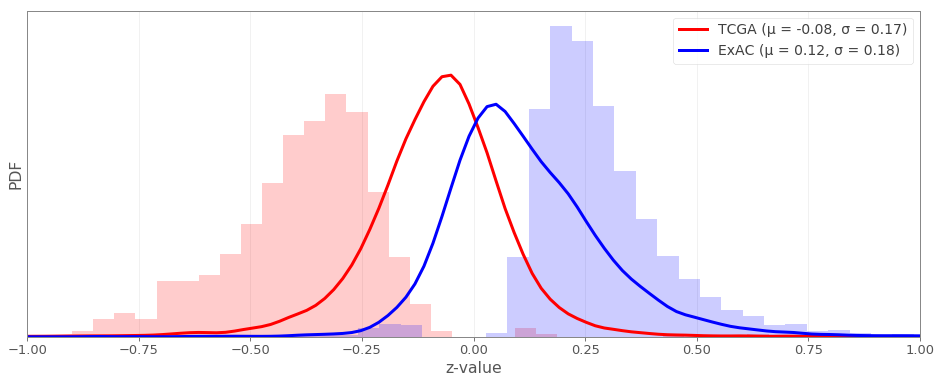

In [38]:
# Draw a graph comparing the distribution of gene z-values between TCGA to ExAC 

with mpl.rc_context(rc = {'font.size': 13}):
    
    fig, ax = plt.subplots(figsize = (16, 6))

    x = np.linspace(-1, 1, 100)
    cancer_pdf, = ax.plot(x, gaussian_kde(cancer_results['overall_z_value'])(x), linewidth = 3, color = 'red')
    exac_pdf, = ax.plot(x, gaussian_kde(exac_results['overall_z_value'])(x), linewidth = 3, color = 'blue')

    ax.hist(cancer_results.loc[cancer_results['overall_fdr_significance'], 'overall_z_value'], \
            normed = 1, bins = 45, alpha = 0.2, color = 'red')
    ax.hist(exac_results.loc[exac_results['overall_fdr_significance'], 'overall_z_value'], \
            normed = 1, bins = 45, alpha = 0.2, color = 'blue')

    cancer_label = 'TCGA (μ = %.2f, σ = %.2f)'.decode('utf8') % (cancer_results['overall_z_value'].mean(), \
            cancer_results['overall_z_value'].std())
    exac_label = 'ExAC (μ = %.2f, σ = %.2f)'.decode('utf8') % (exac_results['overall_z_value'].mean(), \
            exac_results['overall_z_value'].std())
    legend = ax.legend([cancer_pdf, exac_pdf], [cancer_label, exac_label], fontsize = 14)
    
    for text in legend.get_texts():
        plt.setp(text, color = '#404040')

    ax.set_xlim(-1, 1)
    ax.set_xlabel('z-value')
    ax.set_yticks([])
    ax.set_ylabel('PDF')

    print('%d genes in TCGA, %d in ExAC' % (len(cancer_results), len(exac_results)))
    print('%d significant genes in TCGA, %d in ExAC' % (cancer_results['overall_fdr_significance'].sum(), \
            exac_results['overall_fdr_significance'].sum()))

# Exporting the complete result CSVs into a unified Excel file

In [ ]:
# Requires to install the module: xlsxwriter
excel_writer = pd.ExcelWriter(os.path.join(DATA_DIR, 'full_results.xlsx'), engine = 'xlsxwriter')
header_format = excel_writer.book.add_format({'bold': True})

def append_csv(csv_relative_path, sheet_name):
    
    results = pd.read_csv(os.path.join(DATA_DIR, csv_relative_path), index_col = 0)
    results['refseq_ids'] = results['refseq_ids'].apply(lambda refseq_ids: ', '.join(eval(refseq_ids)))
    
    results.to_excel(excel_writer, sheet_name)
    worksheet = excel_writer.sheets[sheet_name]
    
    for column_index, column_name in enumerate(['gene_index'] + list(results.columns)):
        worksheet.write(0, column_index, column_name, header_format)
        
    for row_index, value in enumerate(results.index):
        worksheet.write(row_index + 1, 0, value)

append_csv('gdc_results_complete/combined.csv', 'TCGA_conbined')
append_csv('gdc_overlooked_results.csv', 'TCGA_conbined_overlooked')

for project_name in project_summaries['tcga_project'].sort_values():
    append_csv('gdc_results_complete/%s.csv' % project_name, 'TCGA_%s' % project_name)
    
append_csv('gdc_results_complete/diff.csv', 'TCGA_diff')
append_csv('exac_results_complete.csv', 'ExAC')

excel_writer.save()
print('Done.')